In [450]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams['figure.figsize'] = [16, 8]
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [451]:
# Read in pre-processed pickle
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f:
    rpi = pickle.load(f)
rpi = rpi.sort_values(by=['census_cbsa_geoid', 'census_zcta5_geoid', 'date'])
rpi.reset_index(drop=True, inplace=True)

# filter for a single market
# rpi_cle = rpi.loc[rpi['census_cbsa_geoid'] == '17460']

# copy with relevant columns
df = rpi[['date', 'census_cbsa_geoid', 'census_zcta5_geoid', 'sfr_rental_index', 
              'sfr_price_index', 'coef', 'nounits', 'occupied_units', 'mfr_occ', 'mfr_mean_rent', 
              'mfr_mean_rent_index', 'mfr_mean_occ_index']].copy()

In [452]:
# subset for time frame that includes MFR data (Jan 2015 - June 2023)
df = df.loc[(df.date >= '2015-01-01') & (df.date <= '2023-06-01')]

In [453]:
# drop incomplete zips
drops = df.loc[df.mfr_occ.isna()].census_zcta5_geoid.unique().tolist()
df.drop(df.loc[df['census_zcta5_geoid'].isin(drops)].index, inplace=True)

In [454]:
# rename columns to Prophet's expected names
df.rename({'date': 'ds', 'sfr_rental_index': 'y'}, axis = 1, inplace = True) 
df.index = pd.DatetimeIndex(df['ds'])
df

,ds,census_cbsa_geoid,census_zcta5_geoid,y,sfr_price_index,coef,nounits,occupied_units,mfr_occ,mfr_mean_rent,mfr_mean_rent_index,mfr_mean_occ_index
ds,,,,,,,,,,,,
2015-01-01,2015-01-01,12060,30002,114.715608,82.331231,-0.224999,592.0,538.940,0.910372,656.507021,100.000000,100.000000
2015-02-01,2015-02-01,12060,30002,115.155485,82.202391,-0.207499,592.0,538.940,0.910372,666.671551,101.548274,100.000000
2015-03-01,2015-03-01,12060,30002,115.694032,82.423472,-0.180874,592.0,540.248,0.912581,652.529304,99.426953,100.242699
2015-04-01,2015-04-01,12060,30002,116.181280,83.115012,-0.145673,592.0,537.196,0.907426,650.034188,99.044577,99.677773
2015-05-01,2015-05-01,12060,30002,117.000157,84.135504,-0.126192,592.0,537.196,0.907426,639.764957,97.464778,99.677773
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,2023-02-01,17460,44333,171.211929,135.672552,0.282341,272.0,269.000,0.988971,1135.625000,116.946070,99.465546
2023-03-01,2023-03-01,17460,44333,171.893592,135.855839,0.332749,272.0,267.992,0.985265,1143.119048,117.605975,99.090825
2023-04-01,2023-04-01,17460,44333,172.815363,136.885857,0.371038,272.0,267.992,0.985265,1146.238095,117.878829,99.090825


### Univariate: Sample Zipcode

In [455]:
# sample df for one zipcode
atl_df_samp = df[df['census_zcta5_geoid'] == '30363']

In [456]:
# initiate Prophet object
model = Prophet()

# fit model
model.fit(atl_df_samp)

06:53:02 - cmdstanpy - INFO - Chain [1] start processing
06:53:03 - cmdstanpy - INFO - Chain [1] done processing


In [457]:
# create future dates for prediction
future = model.make_future_dataframe(periods=12, freq='MS') # set frequency to monthly
future.tail()

,ds
109,2024-02-01
110,2024-03-01
111,2024-04-01
112,2024-05-01
113,2024-06-01


In [458]:
# forecast object contains yhat for all time stamps

forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-01,114.900501,111.420104,118.495479
1,2015-02-01,116.379742,112.762951,119.750807
2,2015-03-01,117.906031,114.219072,121.576896
3,2015-04-01,118.719469,115.066447,122.206131
4,2015-05-01,120.098317,116.252051,123.721921
5,2015-06-01,120.927929,117.475570,124.688995
6,2015-07-01,125.636736,121.831181,129.136778
7,2015-08-01,127.002020,123.528194,130.397753
8,2015-09-01,127.848093,124.303940,131.590615
9,2015-10-01,129.253970,125.823306,132.825891


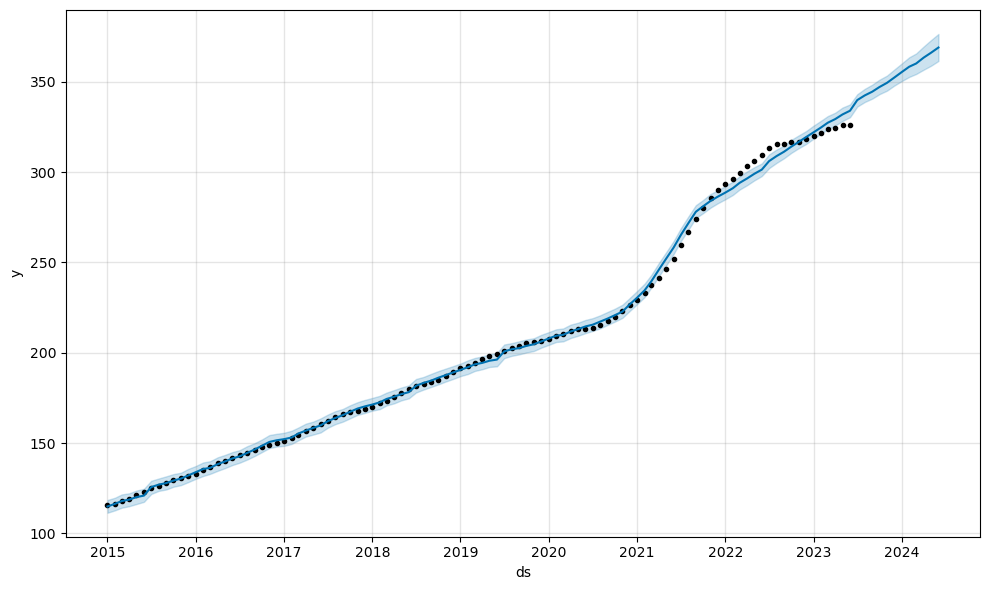

In [459]:
# plot prediction
fig1 = model.plot(forecast)

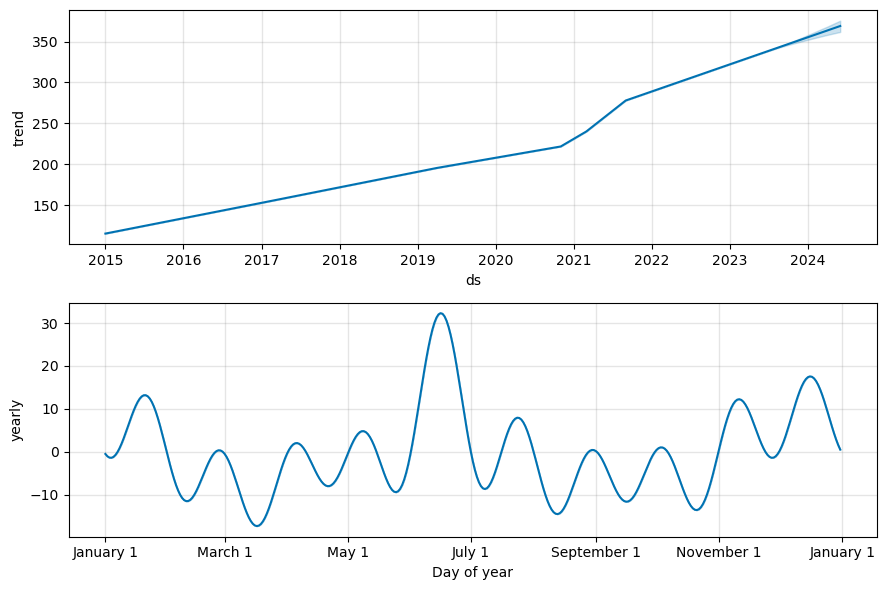

In [460]:
# plot decomposition results
fig2 = model.plot_components(forecast)

In [461]:
forecast.set_index('ds', inplace = True)

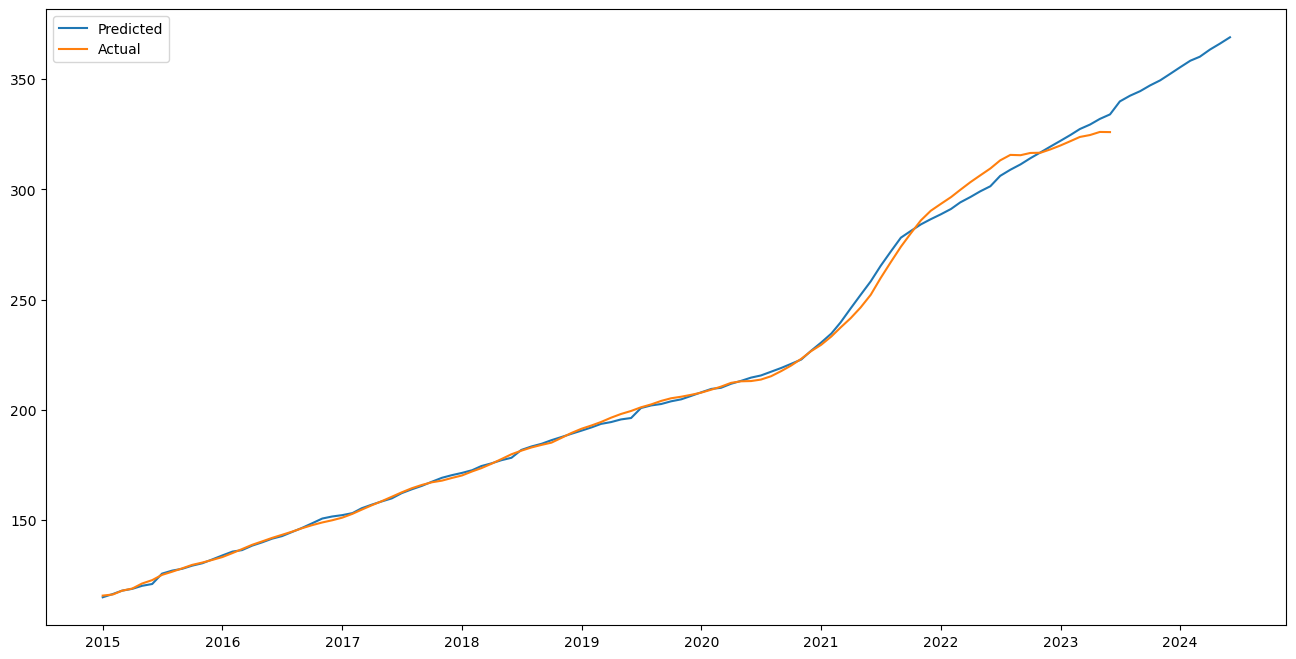

In [462]:
# plot actual vs predicted
y_true = atl_df_samp['y']
y_pred = forecast['yhat']

plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='Actual')

plt.legend()
plt.show()

### Univariate: Train Test Split (Sample Zipcode)

In [463]:
# create train test split
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 2, test_size = 6) # hold out 6 months as test set

for train_index, test_index in tss.split(atl_df_samp):
    df_train, df_test = atl_df_samp.iloc[train_index, :], atl_df_samp.iloc[test_index,:]

In [464]:
df_train.index

DatetimeIndex(['2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01',
               '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01',
               '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01',
               '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
               '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
      

In [336]:
df_test.index

DatetimeIndex(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [465]:
# initiate Prophet object
model = Prophet()

# fit model
model.fit(df_train) # fit on training only

06:54:07 - cmdstanpy - INFO - Chain [1] start processing
06:54:08 - cmdstanpy - INFO - Chain [1] done processing


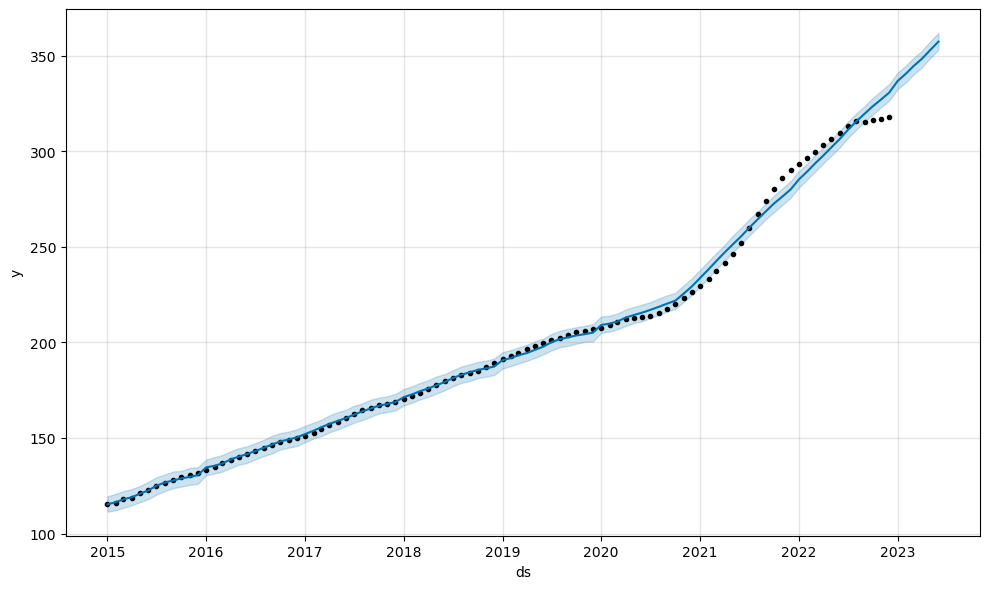

In [466]:
# make yhat predictions on entire data set
forecast = model.predict(atl_df_samp)
fig1 = model.plot(forecast)

In [467]:
# calculate error between expected and predicted values on test set

y_true_train = atl_df_samp.iloc[train_index, :]['y'].values
y_pred_train = forecast.iloc[train_index, :]['yhat'].values
y_true_test = atl_df_samp.iloc[test_index, :]['y'].values
y_pred_test = forecast.iloc[test_index, :]['yhat'].values

print('Train MAPE: %.3f' % mean_absolute_percentage_error(y_true_train, y_pred_train))
print('Train MAE: %.3f' % mean_absolute_error(y_true_train, y_pred_train))
print('Train MSE: %.3f' % mean_squared_error(y_true_train, y_pred_train))
print('--')
print('Test MAPE: %.3f' % mean_absolute_percentage_error(y_true_test, y_pred_test))
print('Test MAE: %.3f' % mean_absolute_error(y_true_test, y_pred_test))
print('Test MSE: %.3f' % mean_squared_error(y_true_test, y_pred_test))

Train MAPE: 0.008
Train MAE: 2.053
Train MSE: 11.208
--
Test MAPE: 0.071
Test MAE: 22.998
Test MSE: 553.380


In [468]:
# to plot true and predicted, need time index
forecast.set_index('ds', inplace = True)

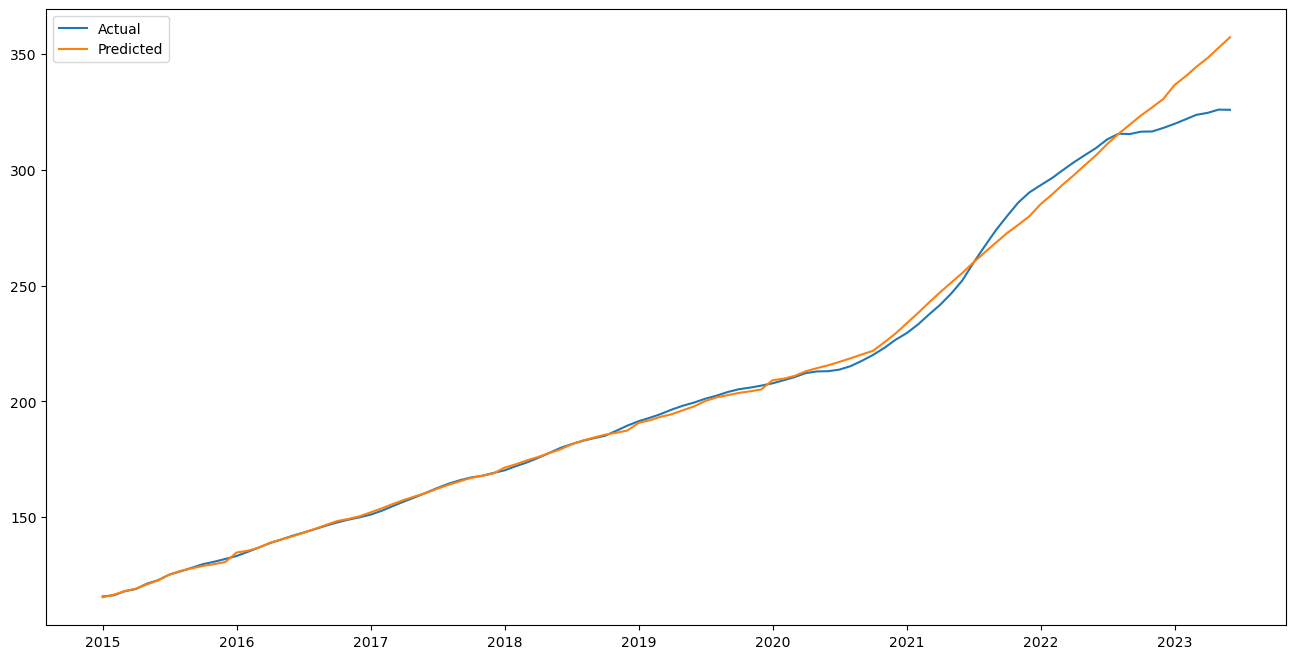

In [469]:
# plot actual vs predicted
y_true = atl_df_samp['y']
y_pred = forecast['yhat']

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

### Univariate - 3-fold Cross-Validation (Sample Zipcode)

In [470]:
# initiate Prophet object
model = Prophet()

model.fit(atl_df_samp)

06:55:39 - cmdstanpy - INFO - Chain [1] start processing
06:55:39 - cmdstanpy - INFO - Chain [1] done processing


In [471]:
cutoffs = pd.to_datetime(['2021-12-01', '2022-06-01', '2022-12-01'])
df_cv_uni = cross_validation(model, cutoffs=cutoffs, horizon='182 days')
df_cv_uni

  0%|          | 0/3 [00:00<?, ?it/s]

06:55:43 - cmdstanpy - INFO - Chain [1] start processing
06:55:43 - cmdstanpy - INFO - Chain [1] done processing
06:55:43 - cmdstanpy - INFO - Chain [1] start processing
06:55:44 - cmdstanpy - INFO - Chain [1] done processing
06:55:45 - cmdstanpy - INFO - Chain [1] start processing
06:55:45 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-01,285.139031,281.874923,288.315930,293.418056,2021-12-01
1,2022-02-01,289.226395,286.107118,292.523885,296.494133,2021-12-01
2,2022-03-01,293.436244,290.423845,296.829823,299.756965,2021-12-01
3,2022-04-01,298.147743,295.069173,301.386298,303.260990,2021-12-01
4,2022-05-01,302.907212,299.614966,306.350350,306.343108,2021-12-01
5,2022-06-01,307.524675,304.226584,310.945725,309.480060,2021-12-01
6,2022-07-01,320.968331,319.122831,322.722618,313.165805,2022-06-01
7,2022-08-01,326.377178,324.510613,328.110171,315.642447,2022-06-01
8,2022-09-01,331.819521,329.931814,333.817930,315.502101,2022-06-01
9,2022-10-01,336.790574,334.899936,338.772154,316.521201,2022-06-01


In [472]:
perf_uni = performance_metrics(df_cv_uni)
perf_uni

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,60.879407,7.802526,7.802526,0.024915,0.024915,0.024608,0.0
1,31 days,175.198899,13.236272,12.533789,0.040346,0.040346,0.039877,0.0
2,61 days,115.234447,10.734731,10.734731,0.034009,0.034009,0.033441,0.0
3,62 days,200.372839,14.155311,12.960252,0.041226,0.041226,0.040563,0.0
4,90 days,234.704429,15.320066,13.522037,0.042545,0.042545,0.041665,0.0
5,92 days,266.258194,16.317420,16.317420,0.051719,0.051719,0.050415,0.0
6,121 days,294.295593,17.155046,14.414595,0.044955,0.044955,0.043740,0.0
7,122 days,410.847470,20.269373,20.269373,0.064038,0.064038,0.062051,0.0
8,151 days,364.042604,19.079901,15.099651,0.046649,0.046649,0.045063,0.5
9,153 days,633.728358,25.173962,25.173962,0.079507,0.079507,0.076468,0.0


In [474]:
print("Mean MAPE: ", round(performance_metrics(df_cv_uni)["mape"].mean(),4))
print("Mean MAE: ", round(performance_metrics(df_cv_uni)["mae"].mean(),4))
print("Mean MSE: ", round(performance_metrics(df_cv_uni)["mse"].mean(),4))

Mean MAPE:  0.0474
Mean MAE:  15.0434
Mean MSE:  295.3303


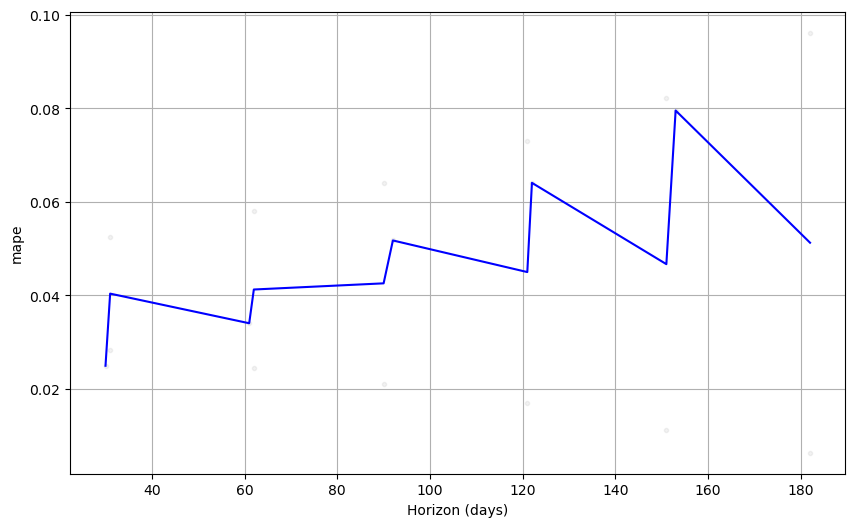

In [473]:
fig = plot_cross_validation_metric(df_cv_uni, metric='mape')

### Multivariate: 3-fold Cross Validation (Sample Zipcode)

In [475]:
# initiate Prophet object
model = Prophet()
model.add_regressor('mfr_mean_rent')
model.fit(atl_df_samp)

06:56:15 - cmdstanpy - INFO - Chain [1] start processing
06:56:15 - cmdstanpy - INFO - Chain [1] done processing


In [476]:
cutoffs = pd.to_datetime(['2021-12-01', '2022-06-01', '2022-12-01'])
df_cv_multi = cross_validation(model, cutoffs=cutoffs, horizon='182 days')
df_cv_multi

  0%|          | 0/3 [00:00<?, ?it/s]

06:56:20 - cmdstanpy - INFO - Chain [1] start processing
06:56:22 - cmdstanpy - INFO - Chain [1] done processing
06:56:22 - cmdstanpy - INFO - Chain [1] start processing
06:56:23 - cmdstanpy - INFO - Chain [1] done processing
06:56:23 - cmdstanpy - INFO - Chain [1] start processing
06:56:24 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2022-01-01,286.927369,284.955301,288.944507,293.418056,2021-12-01
1,2022-02-01,290.036165,288.027839,292.078017,296.494133,2021-12-01
2,2022-03-01,294.451936,292.337022,296.605992,299.756965,2021-12-01
3,2022-04-01,298.721906,296.612276,300.600350,303.260990,2021-12-01
4,2022-05-01,303.020327,300.715905,305.461838,306.343108,2021-12-01
5,2022-06-01,308.933656,306.596663,311.360311,309.480060,2021-12-01
6,2022-07-01,320.502502,319.046341,321.987127,313.165805,2022-06-01
7,2022-08-01,326.343451,324.850696,327.914145,315.642447,2022-06-01
8,2022-09-01,332.281956,330.630348,333.805636,315.502101,2022-06-01
9,2022-10-01,337.824577,336.183967,339.564239,316.521201,2022-06-01


In [477]:
print("Mean MAPE: ", round(performance_metrics(df_cv_multi)["mape"].mean(),4))
print("Mean MAE: ", round(performance_metrics(df_cv_multi)["mae"].mean(),4))
print("Mean MSE: ", round(performance_metrics(df_cv_multi)["mse"].mean(),4))

Mean MAPE:  0.0376
Mean MAE:  11.8898
Mean MSE:  185.9595


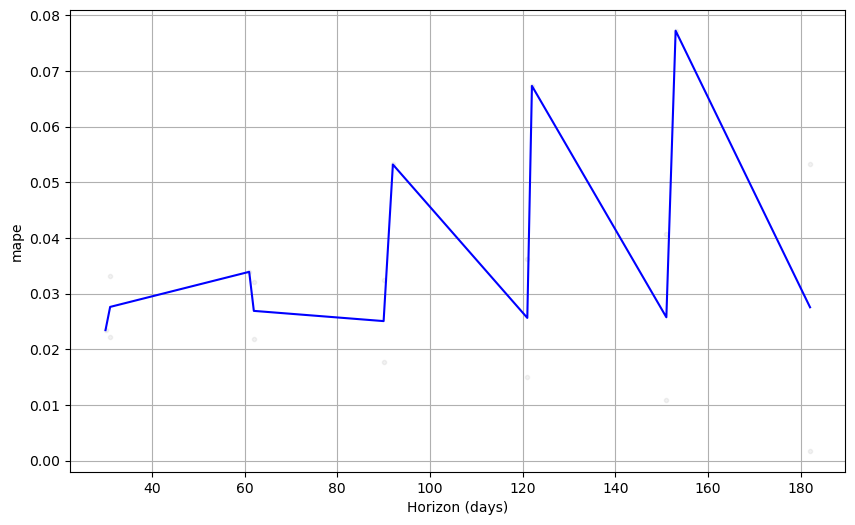

In [478]:
fig = plot_cross_validation_metric(df_cv_multi, metric='mape')

In [479]:
perf_multi = performance_metrics(df_cv_multi)
perf_multi

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,53.827121,7.336697,7.336697,0.023428,0.023428,0.023156,0.0
1,31 days,77.060974,8.778438,8.536679,0.027600,0.027600,0.027454,0.0
2,61 days,114.511480,10.701004,10.701004,0.033902,0.033902,0.033337,0.0
3,62 days,73.895544,8.596252,8.378881,0.026888,0.026888,0.026756,0.0
4,90 days,69.115531,8.313575,7.898649,0.025051,0.025051,0.024872,0.0
5,92 days,281.563520,16.779855,16.779855,0.053185,0.053185,0.051807,0.0
6,121 days,79.689280,8.926885,8.159688,0.025627,0.025627,0.025360,0.0
7,122 days,453.833836,21.303376,21.303376,0.067305,0.067305,0.065114,0.0
8,151 days,93.268444,9.657559,8.285136,0.025738,0.025738,0.025363,0.0
9,153 days,597.714522,24.448201,24.448201,0.077215,0.077215,0.074345,0.0


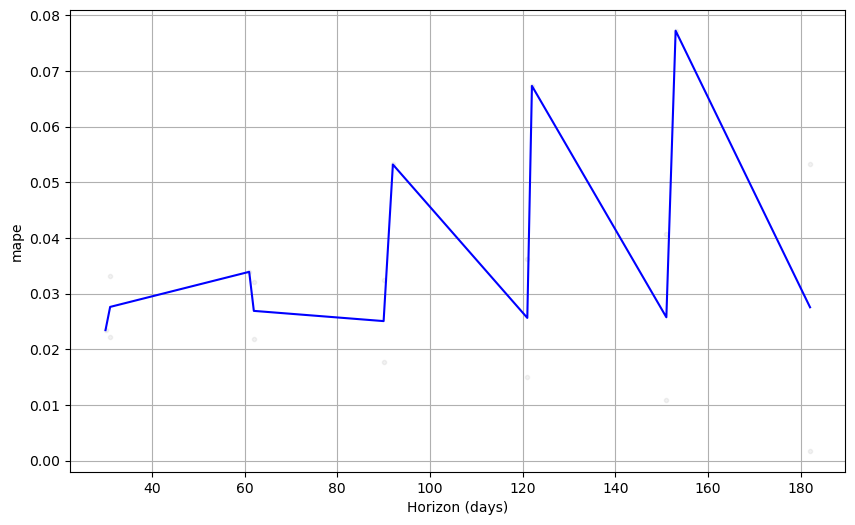

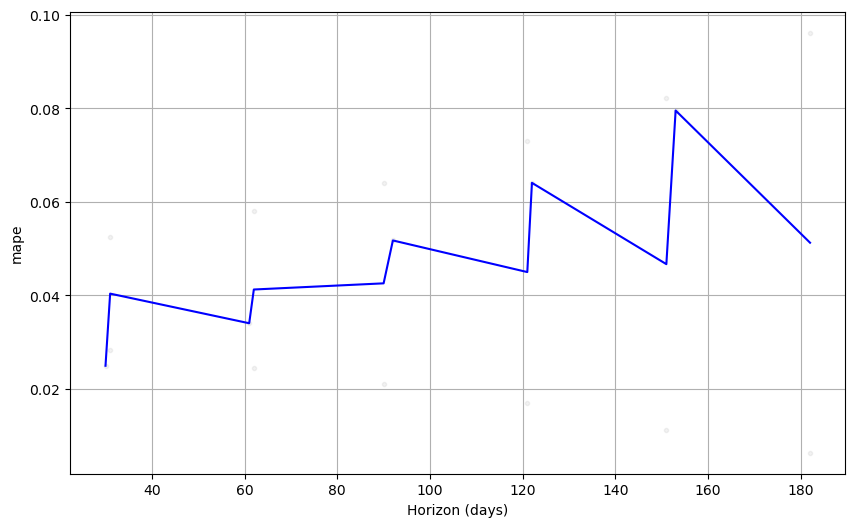

In [480]:
fig1 = plot_cross_validation_metric(df_cv_multi, metric='mape')
fig2 = plot_cross_validation_metric(df_cv_uni, metric='mape')
# similar distribution of error with and without added regressor
# multivariate has greater jumps

### Cross-Validation, Varying Folds

In [481]:
# initiate Prophet object
model = Prophet()
model.add_regressor('mfr_mean_rent')
model.fit(atl_df_samp)

06:59:09 - cmdstanpy - INFO - Chain [1] start processing
06:59:09 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
# 8 folds, Dec cutoffs
# get warning that initial window doesn't include full seasonal period
cutoffs = pd.to_datetime(['2015-12-01', '2016-12-01', '2017-12-01', '2018-12-01', 
                          '2019-12-01', '2020-12-01', '2021-12-01', '2022-12-01'])
df_cv_multi = cross_validation(model, cutoffs=cutoffs, horizon='180 days')
df_cv_multi

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/8 [00:00<?, ?it/s]

16:50:16 - cmdstanpy - INFO - Chain [1] start processing
16:50:18 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:37 - cmdstanpy - INFO - Chain [1] done processing
16:50:37 - cmdstanpy - INFO - Chain [1] start processing
16:51:05 - cmdstanpy - INFO - Chain [1] done processing
16:51:05 - cmdstanpy - INFO - Chain [1] start processing
16:51:08 - cmdstanpy - INFO - Chain [1] done processing
16:51:08 - cmdstanpy - INFO - Chain [1] start processing
16:51:09 - cmdstanpy - INFO - Chain [1] done processing
16:51:09 - cmdstanpy - INFO - Chain [1] start processing
16:51:11 - cmdstanpy - INFO - Chain [1] done processing
16:51:11 - cmdstanpy - INFO - Chain [1] start processing
16:51:12 - cmdstanpy - INFO - Chain [1] done processing
16:51:12 - cmdstanpy - INFO - Chain [1] start processing
16:51:14 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-01-01,336.425310,335.851461,336.975230,133.147468,2015-12-01
1,2016-02-01,327.372009,325.583336,329.173498,134.965672,2015-12-01
2,2016-03-01,219.141534,215.600444,222.700350,136.772726,2015-12-01
3,2016-04-01,-27.289568,-32.793417,-21.792825,138.718014,2015-12-01
4,2016-05-01,-66.827804,-75.153186,-58.958995,140.233513,2015-12-01
5,2017-01-01,151.731337,151.612357,151.868420,151.045500,2016-12-01
6,2017-02-01,150.239350,149.860653,150.686392,152.772671,2016-12-01
7,2017-03-01,154.713180,153.945362,155.560158,154.653767,2016-12-01
8,2017-04-01,156.206563,155.005903,157.538369,156.657254,2016-12-01
9,2017-05-01,157.612236,155.924812,159.481777,158.501174,2016-12-01


In [54]:
perf_multi = performance_metrics(df_cv_multi)
perf_multi
# coverage is like a confidence interval for yhat upper and lower bounds

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,5189.352907,72.037163,28.605862,0.202748,0.013331,0.120139,0.000000
1,62 days,4655.806475,68.233470,27.832217,0.193159,0.019182,0.119061,0.125000
2,90 days,38.119575,6.174105,4.666450,0.017552,0.013551,0.017612,0.333333
3,91 days,1715.737839,41.421466,23.286995,0.161052,0.006570,0.126233,0.166667
4,121 days,47.923445,6.922676,5.076174,0.019065,0.012981,0.019147,0.500000
5,122 days,6914.337800,83.152497,44.472071,0.310751,0.023640,0.511602,0.250000
6,151 days,65.062236,8.066117,5.886226,0.022479,0.012417,0.022611,0.500000
7,152 days,10752.713257,103.695290,55.337907,0.383333,0.048645,0.514245,0.250000


In [56]:
print("Mean MAPE: ", round(performance_metrics(df_cv_multi)["mape"].mean(),4))
print("Mean MAE: ", round(performance_metrics(df_cv_multi)["mae"].mean(),4))
print("Mean MSE: ", round(performance_metrics(df_cv_multi)["mse"].mean(),4))

Mean MAPE:  0.1638
Mean MAE:  24.3955
Mean MSE:  3672.3817


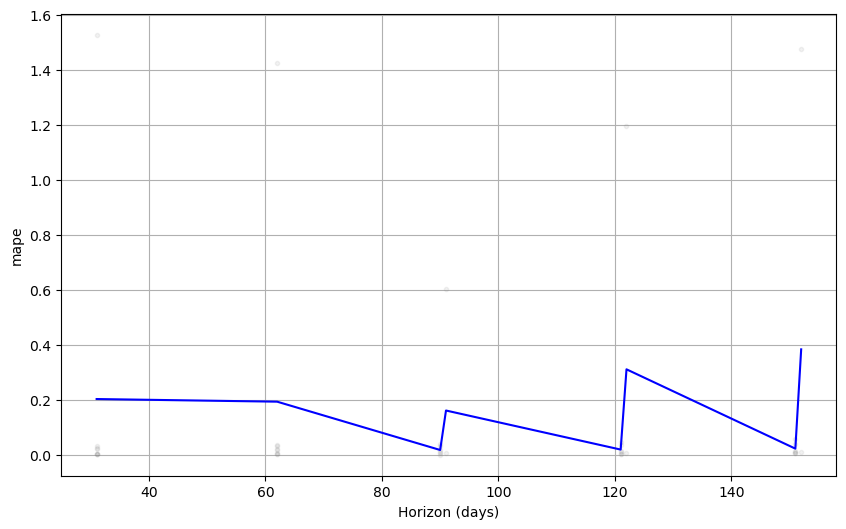

In [55]:
fig = plot_cross_validation_metric(df_cv_multi, metric='mape')

In [57]:
# 8 folds, Jan cutoffs
# still get the same warning
cutoffs = pd.to_datetime(['2016-01-01', '2017-01-01', '2018-01-01', 
                          '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01'])
df_cv_multi = cross_validation(model, cutoffs=cutoffs, horizon='180 days')
df_cv_multi

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

16:53:48 - cmdstanpy - INFO - Chain [1] start processing
16:53:49 - cmdstanpy - INFO - Chain [1] done processing
16:53:49 - cmdstanpy - INFO - Chain [1] start processing
16:54:11 - cmdstanpy - INFO - Chain [1] done processing
16:54:11 - cmdstanpy - INFO - Chain [1] start processing
16:54:43 - cmdstanpy - INFO - Chain [1] done processing
16:54:43 - cmdstanpy - INFO - Chain [1] start processing
16:54:43 - cmdstanpy - INFO - Chain [1] done processing
16:54:43 - cmdstanpy - INFO - Chain [1] start processing
16:54:44 - cmdstanpy - INFO - Chain [1] done processing
16:54:44 - cmdstanpy - INFO - Chain [1] start processing
16:54:45 - cmdstanpy - INFO - Chain [1] done processing
16:54:45 - cmdstanpy - INFO - Chain [1] start processing
16:54:46 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-02-01,-137.252172,-137.644752,-136.892822,134.965672,2016-01-01
1,2016-03-01,-130.767193,-132.073640,-129.601183,136.772726,2016-01-01
2,2016-04-01,-1270.823943,-1273.318373,-1268.588297,138.718014,2016-01-01
3,2016-05-01,-447.497328,-451.336318,-443.792677,140.233513,2016-01-01
4,2016-06-01,-2643.275174,-2648.405624,-2638.054614,141.858439,2016-01-01
5,2017-02-01,150.556270,150.355696,150.798350,152.772671,2017-01-01
6,2017-03-01,153.067261,152.430285,153.823283,154.653767,2017-01-01
7,2017-04-01,154.559869,153.314635,156.031210,156.657254,2017-01-01
8,2017-05-01,156.437756,154.425230,158.672017,158.501174,2017-01-01
9,2017-06-01,158.230287,155.355567,161.376504,160.520010,2017-01-01


In [58]:
perf_multi = performance_metrics(df_cv_multi)
perf_multi

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,1.059634e+04,102.938547,41.056632,0.297715,0.014508,0.295384,0.000000
1,59 days,1.353133e+01,3.678495,2.966047,0.013222,0.010258,0.013323,0.000000
2,60 days,2.386403e+04,154.479856,90.491525,0.657972,0.008997,0.672638,0.000000
3,90 days,1.663046e+01,4.078046,3.007079,0.013431,0.008482,0.013572,0.200000
4,91 days,6.622756e+05,813.803140,471.256913,3.393464,0.013388,0.673104,0.066667
5,120 days,2.555403e+01,5.055100,3.368040,0.015064,0.009874,0.015269,0.600000
6,121 days,1.151524e+05,339.341190,197.718789,1.405272,0.044032,0.674962,0.200000
7,151 days,4.284610e+01,6.545693,4.558462,0.020160,0.013277,0.020458,0.600000
8,152 days,2.585676e+06,1608.003594,931.170448,6.557093,0.017929,0.679409,0.200000


In [64]:
print("Mean MAPE: ", round(performance_metrics(df_cv_multi)["mape"].mean(),4))
print("Mean MAE: ", round(performance_metrics(df_cv_multi)["mae"].mean(),4))
print("Mean MSE: ", round(performance_metrics(df_cv_multi)["mse"].mean(),4))

Mean MAPE:  1.3748
Mean MAE:  193.9549
Mean MSE:  377518.0538


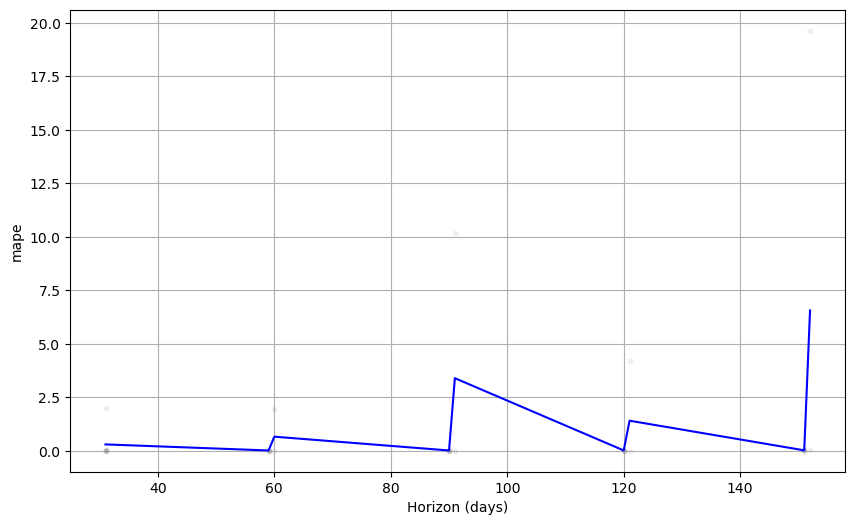

In [59]:
fig = plot_cross_validation_metric(df_cv_multi, metric='mape')

In [61]:
# 6 folds, starting with 2 years

# initial training period
initial= 2*365
initial= str(initial)+' days'

# set period, the additional time to add to training for subsequent fold
period= 365
period=str(period)+' days'

# length of forecast 
horizon = 180
horizon=str(horizon)+' days'

fb_cv=cross_validation(model,initial=initial,period=period,horizon=horizon)
fb_cv

  0%|          | 0/6 [00:00<?, ?it/s]

17:01:27 - cmdstanpy - INFO - Chain [1] start processing
17:01:54 - cmdstanpy - INFO - Chain [1] done processing
17:01:54 - cmdstanpy - INFO - Chain [1] start processing
17:01:55 - cmdstanpy - INFO - Chain [1] done processing
17:01:55 - cmdstanpy - INFO - Chain [1] start processing
17:01:55 - cmdstanpy - INFO - Chain [1] done processing
17:01:55 - cmdstanpy - INFO - Chain [1] start processing
17:01:56 - cmdstanpy - INFO - Chain [1] done processing
17:01:56 - cmdstanpy - INFO - Chain [1] start processing
17:01:57 - cmdstanpy - INFO - Chain [1] done processing
17:01:57 - cmdstanpy - INFO - Chain [1] start processing
17:01:58 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-01,170.708233,170.455661,170.953686,170.177652,2017-12-04
1,2018-02-01,172.624581,171.787334,173.408883,172.004894,2017-12-04
2,2018-03-01,175.120787,173.440507,176.596628,173.489305,2017-12-04
3,2018-04-01,177.414469,174.671836,179.871118,175.485054,2017-12-04
4,2018-05-01,180.076212,176.188661,183.647575,177.592324,2017-12-04
5,2018-06-01,182.924659,177.728562,187.721741,179.794193,2017-12-04
6,2019-01-01,191.775249,191.565863,191.985435,191.391952,2018-12-04
7,2019-02-01,193.893489,193.282213,194.626490,192.903184,2018-12-04
8,2019-03-01,195.640286,194.412534,197.067343,194.421476,2018-12-04
9,2019-04-01,197.029000,195.150373,199.289211,196.399801,2018-12-04


In [62]:
# Performance Metrics of fb_cv
performance_metrics(fb_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,0.350138,0.591724,0.567512,0.002972,0.003118,0.002967,0.000000
1,29 days,63.807108,7.987935,7.726893,0.027271,0.026613,0.027293,0.000000
2,59 days,0.790425,0.889058,0.871089,0.004511,0.004797,0.004501,0.333333
3,60 days,72.488115,8.513995,8.368271,0.029853,0.031994,0.029982,0.000000
4,87 days,25.545115,5.054218,3.739521,0.015175,0.009404,0.015197,0.666667
5,88 days,56.664600,7.527589,6.633817,0.024032,0.025051,0.024132,0.000000
6,118 days,20.261044,4.501227,3.064144,0.012744,0.010995,0.012755,0.666667
7,119 days,71.551556,8.458815,7.294023,0.026366,0.025627,0.026495,0.000000
8,148 days,26.573988,5.154996,3.730792,0.015831,0.008145,0.015834,0.666667
9,149 days,96.938100,9.845715,8.261981,0.029991,0.026228,0.030199,0.000000


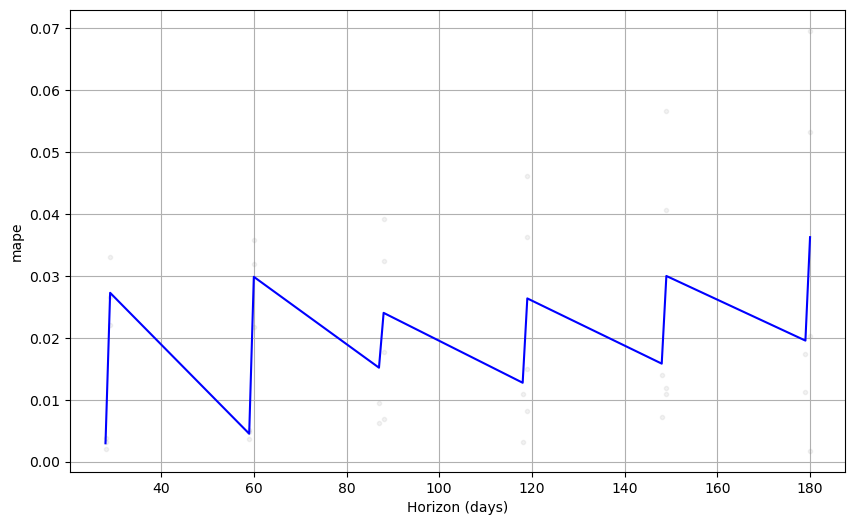

In [63]:
fig = plot_cross_validation_metric(fb_cv, metric='mape')

In [66]:
# 8 folds, starting with 1 year

# initial training period
initial= 366
initial= str(initial)+' days'

# additional time to add to training for subsequent fold
period= 365
period=str(period)+' days'

# length of forecast 
horizon = 180
horizon=str(horizon)+' days'

fb_cv=cross_validation(model,initial=initial,period=period,horizon=horizon)
fb_cv

  0%|          | 0/7 [00:00<?, ?it/s]

17:11:04 - cmdstanpy - INFO - Chain [1] start processing
17:11:22 - cmdstanpy - INFO - Chain [1] done processing
17:11:22 - cmdstanpy - INFO - Chain [1] start processing
17:11:59 - cmdstanpy - INFO - Chain [1] done processing
17:11:59 - cmdstanpy - INFO - Chain [1] start processing
17:12:00 - cmdstanpy - INFO - Chain [1] done processing
17:12:00 - cmdstanpy - INFO - Chain [1] start processing
17:12:01 - cmdstanpy - INFO - Chain [1] done processing
17:12:01 - cmdstanpy - INFO - Chain [1] start processing
17:12:02 - cmdstanpy - INFO - Chain [1] done processing
17:12:03 - cmdstanpy - INFO - Chain [1] start processing
17:12:04 - cmdstanpy - INFO - Chain [1] done processing
17:12:04 - cmdstanpy - INFO - Chain [1] start processing
17:12:05 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-01-01,151.731337,151.609944,151.861507,151.045500,2016-12-04
1,2017-02-01,150.239350,149.844715,150.675589,152.772671,2016-12-04
2,2017-03-01,154.713180,153.901347,155.529609,154.653767,2016-12-04
3,2017-04-01,156.206563,154.970952,157.528099,156.657254,2016-12-04
4,2017-05-01,157.612236,155.875055,159.470869,158.501174,2016-12-04
5,2017-06-01,159.095793,156.867486,161.492675,160.520010,2016-12-04
6,2018-01-01,170.708233,170.432446,171.016843,170.177652,2017-12-04
7,2018-02-01,172.624581,171.737394,173.570586,172.004894,2017-12-04
8,2018-03-01,175.120787,173.422770,176.915106,173.489305,2017-12-04
9,2018-04-01,177.414469,174.611460,180.140560,175.485054,2017-12-04


In [67]:
# Performance Metrics of fb_cv
performance_metrics(fb_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,28 days,0.380197,0.616601,0.597093,0.003364,0.003457,0.003358,0.0000
1,29 days,47.950380,6.924621,5.944443,0.021294,0.024367,0.021310,0.0000
2,59 days,2.197247,1.482311,1.286647,0.007529,0.004966,0.007556,0.2500
3,60 days,54.915398,7.410492,6.597865,0.024272,0.026888,0.024376,0.0625
4,87 days,19.159719,4.377182,2.819494,0.011477,0.007836,0.011494,0.7500
5,88 days,56.664600,7.527589,6.633817,0.024032,0.025051,0.024132,0.0000
6,118 days,15.246564,3.904685,2.410780,0.010277,0.005038,0.010287,0.7500
7,119 days,71.551556,8.458815,7.294023,0.026366,0.025627,0.026495,0.0000
8,148 days,20.128044,4.486429,3.020328,0.013275,0.010564,0.013281,0.7500
9,149 days,96.938100,9.845715,8.261981,0.029991,0.026228,0.030199,0.0000


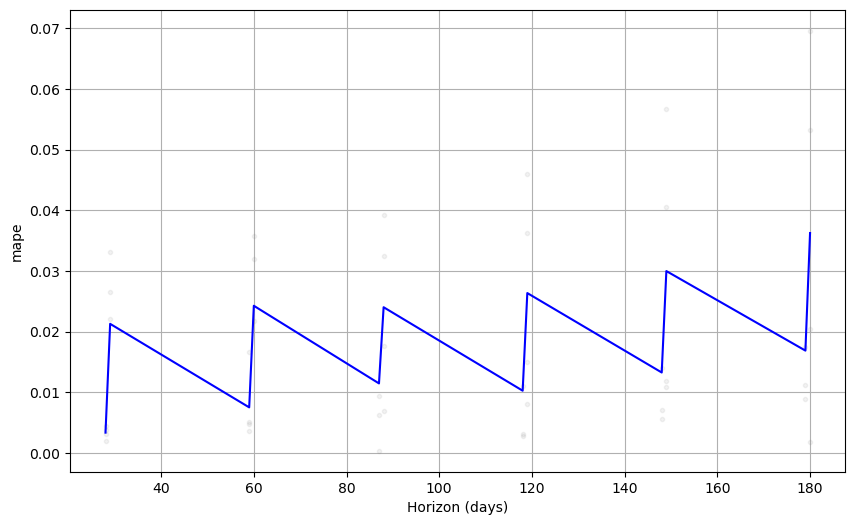

In [68]:
fig = plot_cross_validation_metric(fb_cv, metric='mape')

In [69]:
print("Mean MAPE: ", round(performance_metrics(fb_cv)["mape"].mean(),4))
print("Mean MAE: ", round(performance_metrics(fb_cv)["mae"].mean(),4))
print("Mean MSE: ", round(performance_metrics(fb_cv)["mse"].mean(),4))

Mean MAPE:  0.0188
Mean MAE:  4.882
Mean MSE:  47.5695


In [ ]:
# use defaults from doctsring

# if parameters not provided,
# period is 0.5*horizon
# initial is 3*horizon

In [72]:
# length of forecast 
horizon = 180
horizon=str(horizon)+' days'

# initial is 18 months
# period is 3 months

fb_cv=cross_validation(model,horizon=horizon)
fb_cv

  0%|          | 0/27 [00:00<?, ?it/s]

17:28:50 - cmdstanpy - INFO - Chain [1] start processing
17:29:09 - cmdstanpy - INFO - Chain [1] done processing
17:29:09 - cmdstanpy - INFO - Chain [1] start processing
17:29:30 - cmdstanpy - INFO - Chain [1] done processing
17:29:30 - cmdstanpy - INFO - Chain [1] start processing
17:29:53 - cmdstanpy - INFO - Chain [1] done processing
17:29:53 - cmdstanpy - INFO - Chain [1] start processing
17:30:09 - cmdstanpy - INFO - Chain [1] done processing
17:30:09 - cmdstanpy - INFO - Chain [1] start processing
17:30:34 - cmdstanpy - INFO - Chain [1] done processing
17:30:34 - cmdstanpy - INFO - Chain [1] start processing
17:31:07 - cmdstanpy - INFO - Chain [1] done processing
17:31:07 - cmdstanpy - INFO - Chain [1] start processing
17:31:35 - cmdstanpy - INFO - Chain [1] done processing
17:31:35 - cmdstanpy - INFO - Chain [1] start processing
17:31:36 - cmdstanpy - INFO - Chain [1] done processing
17:31:36 - cmdstanpy - INFO - Chain [1] start processing
17:31:37 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-08-01,330.075075,329.586699,330.517560,144.692351,2016-07-07
1,2016-09-01,-118.953480,-120.557429,-117.478594,146.274457,2016-07-07
2,2016-10-01,188.979600,185.880511,191.889296,147.632070,2016-07-07
3,2016-11-01,151.862195,146.911700,156.555830,148.859222,2016-07-07
4,2016-12-01,313.175659,306.130884,319.877631,149.839978,2016-07-07
5,2017-01-01,72.747488,63.320168,81.796544,151.045500,2016-07-07
6,2016-11-01,155.513390,155.462588,155.563035,148.859222,2016-10-05
7,2016-12-01,160.397011,160.236704,160.553424,149.839978,2016-10-05
8,2017-01-01,151.621942,151.297809,151.921500,151.045500,2016-10-05
9,2017-02-01,150.039623,149.526186,150.532898,152.772671,2016-10-05


In [81]:
# resulting in 27 folds
len(fb_cv['cutoff'].unique())

27

In [73]:
# horizon represents number of days from cutoff
# since our data is monthly, but cutoffs are not, the next data point can be any length away
performance_metrics(fb_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,5.210648,2.282684,1.403187,0.006263,0.003460,0.006301,0.06250
1,22 days,5.872689,2.423363,1.574911,0.006793,0.003701,0.006835,0.06250
2,24 days,8.473808,2.910981,1.935005,0.007838,0.003701,0.007896,0.12500
3,25 days,2159.740647,46.473010,13.932171,0.089117,0.007770,0.057891,0.12500
4,27 days,2177.437303,46.663019,15.274861,0.094759,0.010969,0.063399,0.12500
5,28 days,2177.509000,46.663787,15.310383,0.095044,0.010969,0.063682,0.12500
6,29 days,2184.776695,46.741595,16.060015,0.097776,0.018071,0.066387,0.06250
7,30 days,2184.773798,46.741564,16.049203,0.097729,0.018071,0.066341,0.12500
8,32 days,2184.619910,46.739918,15.996063,0.097562,0.018071,0.066175,0.12500
9,33 days,2184.522823,46.738879,15.954007,0.097426,0.018071,0.066038,0.12500


In [75]:
print("Mean MAPE: ", round(performance_metrics(fb_cv)["mape"].mean(),4))
print("Mean MAE: ", round(performance_metrics(fb_cv)["mae"].mean(),4))
print("Mean MSE: ", round(performance_metrics(fb_cv)["mse"].mean(),4))

Mean MAPE:  0.0514
Mean MAE:  9.6179
Mean MSE:  994.298


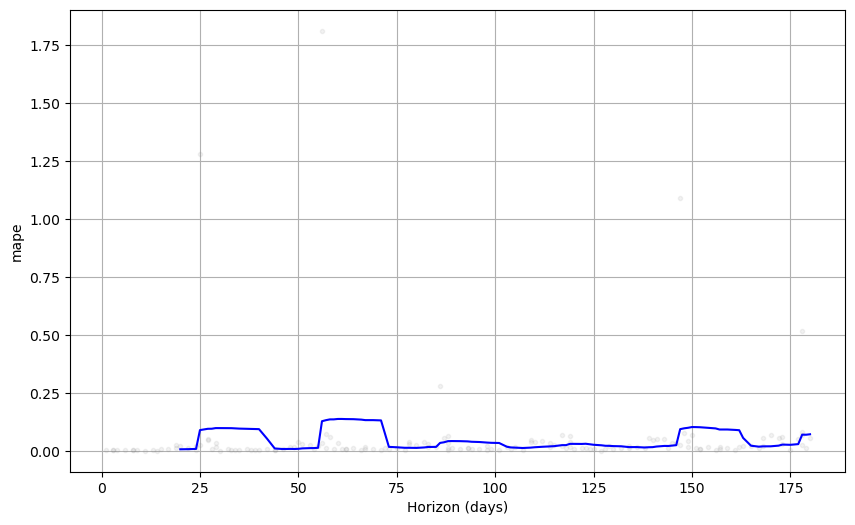

In [74]:
fig = plot_cross_validation_metric(fb_cv, metric='mape')

### Comparing Cross-Validation Methods, by Zip

In [490]:
# CREATE ATL DF
atl_df = df[df['census_cbsa_geoid'] == '12060']

# initate data frame to store results
output = pd.DataFrame(columns = ['zip', 'model', 'mape', 'mae', 'mse'])

In [492]:
# 1 year initial, 1 year period, 6 mos forecast

for zipcode in atl_df['census_zcta5_geoid'].unique():
    # filter for single zipcode
    zipcode_df = atl_df[atl_df['census_zcta5_geoid'] == zipcode]
    
    # initiate Prophet object and fit on zipcode 
    model = Prophet()
    model.fit(zipcode_df)
    
    # initial training period
    initial= pd.to_timedelta(366,unit="D")

    # additional time to add to training for subsequent fold
    period= pd.to_timedelta(365,unit="D")

    # length of forecast 
    horizon = pd.to_timedelta(180,unit="D")
    
    df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon, parallel="processes")

    output_zip = []
    output_zip.append(zipcode)
    output_zip.append('crossval_1yr_1yr_6mos')
    output_zip.append(performance_metrics(df_cv)['mape'].mean())
    output_zip.append(performance_metrics(df_cv)['mae'].mean())
    output_zip.append(performance_metrics(df_cv)['mse'].mean())
    output.loc[len(output)] = output_zip

08:24:06 - cmdstanpy - INFO - Chain [1] start processing
08:24:06 - cmdstanpy - INFO - Chain [1] done processing
08:24:11 - cmdstanpy - INFO - Chain [1] start processing
08:24:11 - cmdstanpy - INFO - Chain [1] start processing
08:24:11 - cmdstanpy - INFO - Chain [1] start processing
08:24:11 - cmdstanpy - INFO - Chain [1] start processing
08:24:12 - cmdstanpy - INFO - Chain [1] done processing
08:24:12 - cmdstanpy - INFO - Chain [1] start processing
08:24:12 - cmdstanpy - INFO - Chain [1] done processing
08:24:12 - cmdstanpy - INFO - Chain [1] start processing
08:24:13 - cmdstanpy - INFO - Chain [1] done processing
08:24:13 - cmdstanpy - INFO - Chain [1] start processing
08:24:13 - cmdstanpy - INFO - Chain [1] done processing
08:24:14 - cmdstanpy - INFO - Chain [1] done processing
08:24:35 - cmdstanpy - INFO - Chain [1] done processing
08:24:44 - cmdstanpy - INFO - Chain [1] done processing
08:24:45 - cmdstanpy - INFO - Chain [1] start processing
08:24:45 - cmdstanpy - INFO - Chain [1]

08:41:13 - cmdstanpy - INFO - Chain [1] done processing
08:41:16 - cmdstanpy - INFO - Chain [1] start processing
08:41:16 - cmdstanpy - INFO - Chain [1] start processing
08:41:16 - cmdstanpy - INFO - Chain [1] start processing
08:41:16 - cmdstanpy - INFO - Chain [1] start processing
08:41:17 - cmdstanpy - INFO - Chain [1] done processing
08:41:17 - cmdstanpy - INFO - Chain [1] start processing
08:41:17 - cmdstanpy - INFO - Chain [1] done processing
08:41:18 - cmdstanpy - INFO - Chain [1] start processing
08:41:18 - cmdstanpy - INFO - Chain [1] done processing
08:41:18 - cmdstanpy - INFO - Chain [1] start processing
08:41:19 - cmdstanpy - INFO - Chain [1] done processing
08:41:20 - cmdstanpy - INFO - Chain [1] done processing
08:41:41 - cmdstanpy - INFO - Chain [1] done processing
08:41:49 - cmdstanpy - INFO - Chain [1] done processing
08:41:50 - cmdstanpy - INFO - Chain [1] start processing
08:41:50 - cmdstanpy - INFO - Chain [1] done processing
08:41:53 - cmdstanpy - INFO - Chain [1] 

08:46:49 - cmdstanpy - INFO - Chain [1] start processing
08:46:49 - cmdstanpy - INFO - Chain [1] done processing
08:46:50 - cmdstanpy - INFO - Chain [1] start processing
08:46:50 - cmdstanpy - INFO - Chain [1] done processing
08:46:51 - cmdstanpy - INFO - Chain [1] start processing
08:46:51 - cmdstanpy - INFO - Chain [1] done processing
08:46:51 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing
08:46:53 - cmdstanpy - INFO - Chain [1] done processing
08:47:10 - cmdstanpy - INFO - Chain [1] done processing
08:47:25 - cmdstanpy - INFO - Chain [1] done processing
08:47:26 - cmdstanpy - INFO - Chain [1] start processing
08:47:26 - cmdstanpy - INFO - Chain [1] done processing
08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1] start processing
08:47:29 - cmdstanpy - INFO - Chain [1]

08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:04 - cmdstanpy - INFO - Chain [1] done processing
08:52:04 - cmdstanpy - INFO - Chain [1] start processing
08:52:05 - cmdstanpy - INFO - Chain [1] done processing
08:52:05 - cmdstanpy - INFO - Chain [1] start processing
08:52:05 - cmdstanpy - INFO - Chain [1] done processing
08:52:06 - cmdstanpy - INFO - Chain [1] done processing
08:52:37 - cmdstanpy - INFO - Chain [1] done processing
08:52:47 - cmdstanpy - INFO - Chain [1] done processing
08:52:48 - cmdstanpy - INFO - Chain [1] start processing
08:52:48 - cmdstanpy - INFO - Chain [1] done processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:51 - cmdstanpy - INFO - Chain [1] start processing
08:52:52 - cmdstanpy - INFO - Chain [1] start processing
08:52:52 - cmdstanpy - INFO - Chain [1] done processing
08:52:52 - cmdstanpy - INFO - Chain [1] 

08:59:56 - cmdstanpy - INFO - Chain [1] done processing
08:59:56 - cmdstanpy - INFO - Chain [1] start processing
08:59:57 - cmdstanpy - INFO - Chain [1] done processing
08:59:57 - cmdstanpy - INFO - Chain [1] start processing
08:59:58 - cmdstanpy - INFO - Chain [1] done processing
08:59:59 - cmdstanpy - INFO - Chain [1] done processing
09:00:23 - cmdstanpy - INFO - Chain [1] done processing
09:00:32 - cmdstanpy - INFO - Chain [1] done processing
09:00:33 - cmdstanpy - INFO - Chain [1] start processing
09:00:33 - cmdstanpy - INFO - Chain [1] done processing
09:00:36 - cmdstanpy - INFO - Chain [1] start processing
09:00:36 - cmdstanpy - INFO - Chain [1] start processing
09:00:36 - cmdstanpy - INFO - Chain [1] start processing
09:00:36 - cmdstanpy - INFO - Chain [1] start processing
09:00:37 - cmdstanpy - INFO - Chain [1] done processing
09:00:37 - cmdstanpy - INFO - Chain [1] start processing
09:00:37 - cmdstanpy - INFO - Chain [1] done processing
09:00:37 - cmdstanpy - INFO - Chain [1] 

09:05:32 - cmdstanpy - INFO - Chain [1] done processing
09:05:32 - cmdstanpy - INFO - Chain [1] start processing
09:05:32 - cmdstanpy - INFO - Chain [1] done processing
09:05:33 - cmdstanpy - INFO - Chain [1] done processing
09:05:38 - cmdstanpy - INFO - Chain [1] done processing
09:05:58 - cmdstanpy - INFO - Chain [1] done processing
09:05:59 - cmdstanpy - INFO - Chain [1] start processing
09:05:59 - cmdstanpy - INFO - Chain [1] done processing
09:06:03 - cmdstanpy - INFO - Chain [1] start processing
09:06:03 - cmdstanpy - INFO - Chain [1] start processing
09:06:03 - cmdstanpy - INFO - Chain [1] start processing
09:06:03 - cmdstanpy - INFO - Chain [1] start processing
09:06:04 - cmdstanpy - INFO - Chain [1] done processing
09:06:04 - cmdstanpy - INFO - Chain [1] done processing
09:06:04 - cmdstanpy - INFO - Chain [1] start processing
09:06:04 - cmdstanpy - INFO - Chain [1] start processing
09:06:05 - cmdstanpy - INFO - Chain [1] done processing
09:06:05 - cmdstanpy - INFO - Chain [1] 

09:10:27 - cmdstanpy - INFO - Chain [1] done processing
09:10:28 - cmdstanpy - INFO - Chain [1] done processing
09:10:50 - cmdstanpy - INFO - Chain [1] done processing
09:10:59 - cmdstanpy - INFO - Chain [1] done processing
09:11:00 - cmdstanpy - INFO - Chain [1] start processing
09:11:00 - cmdstanpy - INFO - Chain [1] done processing
09:11:03 - cmdstanpy - INFO - Chain [1] start processing
09:11:03 - cmdstanpy - INFO - Chain [1] start processing
09:11:03 - cmdstanpy - INFO - Chain [1] start processing
09:11:04 - cmdstanpy - INFO - Chain [1] start processing
09:11:04 - cmdstanpy - INFO - Chain [1] done processing
09:11:04 - cmdstanpy - INFO - Chain [1] done processing
09:11:05 - cmdstanpy - INFO - Chain [1] start processing
09:11:05 - cmdstanpy - INFO - Chain [1] start processing
09:11:06 - cmdstanpy - INFO - Chain [1] done processing
09:11:06 - cmdstanpy - INFO - Chain [1] start processing
09:11:07 - cmdstanpy - INFO - Chain [1] done processing
09:11:08 - cmdstanpy - INFO - Chain [1] 

09:16:08 - cmdstanpy - INFO - Chain [1] done processing
09:16:17 - cmdstanpy - INFO - Chain [1] done processing
09:16:18 - cmdstanpy - INFO - Chain [1] start processing
09:16:18 - cmdstanpy - INFO - Chain [1] done processing
09:16:21 - cmdstanpy - INFO - Chain [1] start processing
09:16:21 - cmdstanpy - INFO - Chain [1] start processing
09:16:21 - cmdstanpy - INFO - Chain [1] start processing
09:16:21 - cmdstanpy - INFO - Chain [1] start processing
09:16:22 - cmdstanpy - INFO - Chain [1] done processing
09:16:22 - cmdstanpy - INFO - Chain [1] start processing
09:16:22 - cmdstanpy - INFO - Chain [1] done processing
09:16:22 - cmdstanpy - INFO - Chain [1] start processing
09:16:23 - cmdstanpy - INFO - Chain [1] done processing
09:16:23 - cmdstanpy - INFO - Chain [1] start processing
09:16:24 - cmdstanpy - INFO - Chain [1] done processing
09:16:25 - cmdstanpy - INFO - Chain [1] done processing
09:16:47 - cmdstanpy - INFO - Chain [1] done processing
09:16:56 - cmdstanpy - INFO - Chain [1] 

09:19:54 - cmdstanpy - INFO - Chain [1] start processing
09:19:54 - cmdstanpy - INFO - Chain [1] done processing
09:19:56 - cmdstanpy - INFO - Chain [1] start processing
09:19:56 - cmdstanpy - INFO - Chain [1] start processing
09:19:56 - cmdstanpy - INFO - Chain [1] start processing
09:19:56 - cmdstanpy - INFO - Chain [1] start processing
09:19:56 - cmdstanpy - INFO - Chain [1] done processing
09:19:56 - cmdstanpy - INFO - Chain [1] start processing
09:19:56 - cmdstanpy - INFO - Chain [1] done processing
09:19:56 - cmdstanpy - INFO - Chain [1] start processing
09:19:57 - cmdstanpy - INFO - Chain [1] done processing
09:19:57 - cmdstanpy - INFO - Chain [1] start processing
09:19:57 - cmdstanpy - INFO - Chain [1] done processing
09:19:58 - cmdstanpy - INFO - Chain [1] done processing
09:20:10 - cmdstanpy - INFO - Chain [1] done processing
09:20:15 - cmdstanpy - INFO - Chain [1] done processing
09:20:15 - cmdstanpy - INFO - Chain [1] start processing
09:20:15 - cmdstanpy - INFO - Chain [1]

09:23:08 - cmdstanpy - INFO - Chain [1] done processing
09:23:10 - cmdstanpy - INFO - Chain [1] start processing
09:23:10 - cmdstanpy - INFO - Chain [1] start processing
09:23:10 - cmdstanpy - INFO - Chain [1] start processing
09:23:10 - cmdstanpy - INFO - Chain [1] start processing
09:23:10 - cmdstanpy - INFO - Chain [1] done processing
09:23:10 - cmdstanpy - INFO - Chain [1] start processing
09:23:10 - cmdstanpy - INFO - Chain [1] done processing
09:23:10 - cmdstanpy - INFO - Chain [1] start processing
09:23:11 - cmdstanpy - INFO - Chain [1] done processing
09:23:11 - cmdstanpy - INFO - Chain [1] start processing
09:23:12 - cmdstanpy - INFO - Chain [1] done processing
09:23:13 - cmdstanpy - INFO - Chain [1] done processing
09:23:52 - cmdstanpy - INFO - Chain [1] done processing
09:23:53 - cmdstanpy - INFO - Chain [1] done processing
09:23:53 - cmdstanpy - INFO - Chain [1] start processing
09:23:53 - cmdstanpy - INFO - Chain [1] done processing
09:23:56 - cmdstanpy - INFO - Chain [1] 

09:54:29 - cmdstanpy - INFO - Chain [1] done processing
09:54:30 - cmdstanpy - INFO - Chain [1] done processing
09:54:30 - cmdstanpy - INFO - Chain [1] start processing
09:54:30 - cmdstanpy - INFO - Chain [1] start processing
09:54:30 - cmdstanpy - INFO - Chain [1] done processing
09:54:30 - cmdstanpy - INFO - Chain [1] start processing
09:54:31 - cmdstanpy - INFO - Chain [1] done processing
09:54:32 - cmdstanpy - INFO - Chain [1] done processing
09:54:43 - cmdstanpy - INFO - Chain [1] done processing
09:54:49 - cmdstanpy - INFO - Chain [1] done processing
09:54:49 - cmdstanpy - INFO - Chain [1] start processing
09:54:49 - cmdstanpy - INFO - Chain [1] done processing
09:54:51 - cmdstanpy - INFO - Chain [1] start processing
09:54:51 - cmdstanpy - INFO - Chain [1] start processing
09:54:51 - cmdstanpy - INFO - Chain [1] start processing
09:54:51 - cmdstanpy - INFO - Chain [1] start processing
09:54:52 - cmdstanpy - INFO - Chain [1] done processing
09:54:52 - cmdstanpy - INFO - Chain [1] 

09:57:53 - cmdstanpy - INFO - Chain [1] done processing
09:57:53 - cmdstanpy - INFO - Chain [1] start processing
09:57:53 - cmdstanpy - INFO - Chain [1] done processing
09:57:54 - cmdstanpy - INFO - Chain [1] done processing
09:58:11 - cmdstanpy - INFO - Chain [1] done processing
09:58:17 - cmdstanpy - INFO - Chain [1] done processing
09:58:17 - cmdstanpy - INFO - Chain [1] start processing
09:58:18 - cmdstanpy - INFO - Chain [1] done processing
09:58:20 - cmdstanpy - INFO - Chain [1] start processing
09:58:20 - cmdstanpy - INFO - Chain [1] start processing
09:58:20 - cmdstanpy - INFO - Chain [1] start processing
09:58:20 - cmdstanpy - INFO - Chain [1] start processing
09:58:20 - cmdstanpy - INFO - Chain [1] done processing
09:58:20 - cmdstanpy - INFO - Chain [1] start processing
09:58:20 - cmdstanpy - INFO - Chain [1] done processing
09:58:20 - cmdstanpy - INFO - Chain [1] start processing
09:58:21 - cmdstanpy - INFO - Chain [1] done processing
09:58:21 - cmdstanpy - INFO - Chain [1] 

10:02:18 - cmdstanpy - INFO - Chain [1] done processing
10:02:19 - cmdstanpy - INFO - Chain [1] done processing
10:02:36 - cmdstanpy - INFO - Chain [1] done processing
10:02:43 - cmdstanpy - INFO - Chain [1] done processing
10:02:44 - cmdstanpy - INFO - Chain [1] start processing
10:02:44 - cmdstanpy - INFO - Chain [1] done processing
10:02:46 - cmdstanpy - INFO - Chain [1] start processing
10:02:46 - cmdstanpy - INFO - Chain [1] start processing
10:02:46 - cmdstanpy - INFO - Chain [1] start processing
10:02:46 - cmdstanpy - INFO - Chain [1] start processing
10:02:47 - cmdstanpy - INFO - Chain [1] done processing
10:02:47 - cmdstanpy - INFO - Chain [1] done processing
10:02:47 - cmdstanpy - INFO - Chain [1] start processing
10:02:47 - cmdstanpy - INFO - Chain [1] start processing
10:02:47 - cmdstanpy - INFO - Chain [1] done processing
10:02:47 - cmdstanpy - INFO - Chain [1] start processing
10:02:48 - cmdstanpy - INFO - Chain [1] done processing
10:02:48 - cmdstanpy - INFO - Chain [1] 

10:07:16 - cmdstanpy - INFO - Chain [1] done processing
10:07:24 - cmdstanpy - INFO - Chain [1] done processing


In [493]:
output.head()

,zip,model,mape,mae,mse
0,30002,crossval_1yr_1yr_6mos,0.015618,2.639333,16.228079
1,30004,crossval_1yr_1yr_6mos,0.015206,2.551273,16.846374
2,30005,crossval_1yr_1yr_6mos,0.014968,2.625996,19.362732
3,30008,crossval_1yr_1yr_6mos,0.016838,3.091112,25.662215
4,30009,crossval_1yr_1yr_6mos,0.017543,3.122831,24.221371


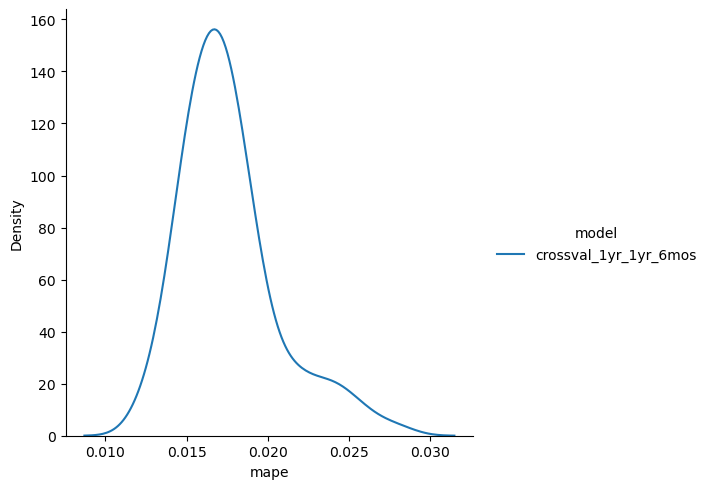

In [494]:
sns.displot(output, x="mape", hue="model", kind="kde")

In [ ]:
# 1 year initial, 6 mos period, 6 mos forecast

for zipcode in atl_df['census_zcta5_geoid'].unique():
    # filter for single zipcode
    zipcode_df = atl_df[atl_df['census_zcta5_geoid'] == zipcode]
    
    # initiate Prophet object and fit on zipcode 
    model = Prophet()
    model.fit(zipcode_df)
    
    # initial training period
    initial= pd.to_timedelta(366,unit="D")

    # additional time to add to training for subsequent fold
    period= pd.to_timedelta(180,unit="D")

    # length of forecast 
    horizon = pd.to_timedelta(180,unit="D")
    
    df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon, parallel="processes")

    output_zip = []
    output_zip.append(zipcode)
    output_zip.append('crossval_1yr_6mos_6mos')
    output_zip.append(performance_metrics(df_cv)['mape'].mean())
    output_zip.append(performance_metrics(df_cv)['mae'].mean())
    output_zip.append(performance_metrics(df_cv)['mse'].mean())
    output.loc[len(output)] = output_zip

### Cross-Validation by Zip

In [399]:
crossval_dict = {}

for zipcode in atl_df['census_zcta5_geoid'].unique():
    # filter for single zipcode
    zipcode_df = atl_df[atl_df['census_zcta5_geoid'] == zipcode]
    
    # initiate Prophet object and fit on zipcode 
    model = Prophet()
    model.fit(zipcode_df)
    
    cutoffs = pd.to_datetime(['2021-12-01', '2022-06-01', '2022-12-01'])
    df_cv = cross_validation(model, cutoffs=cutoffs, horizon='182 days')

    crossval_dict[zipcode] = df_cv

16:22:48 - cmdstanpy - INFO - Chain [1] start processing
16:22:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:22:48 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:23:05 - cmdstanpy - INFO - Chain [1] done processing
16:23:05 - cmdstanpy - INFO - Chain [1] start processing
16:23:05 - cmdstanpy - INFO - Chain [1] done processing
16:23:05 - cmdstanpy - INFO - Chain [1] start processing
16:23:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:23:06 - cmdstanpy - INFO - Chain [1] start processing
16:23:28 - cmdstanpy - INFO - Chain [1] done processing
16:23:28 - cmdstanpy - INFO - Chain [1] start processing
16:23:50 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing
16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:23:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:23:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:24 - cmdstanpy - INFO - Chain [1] done processing
16:26:25 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing
16:26:25 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:25 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
16:26:42 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:19 - cmdstanpy - INFO - Chain [1] done processing
16:27:19 - cmdstanpy - INFO - Chain [1] start processing
16:27:35 - cmdstanpy - INFO - Chain [1] done processing
16:27:35 - cmdstanpy - INFO - Chain [1] start processing
16:27:36 - cmdstanpy - INFO - Chain [1] done processing
16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:27:36 - cmdstanpy - INFO - Chain [1] start processing
16:27:45 - cmdstanpy - INFO - Chain [1] done processing
16:27:45 - cmdstanpy - INFO - Chain [1] start processing
16:28:06 - cmdstanpy - INFO - Chain [1] done processing
16:28:06 - cmdstanpy - INFO - Chain [1] start processing
16:28:06 - cmdstanpy - INFO - Chain [1] done processing
16:28:06 - cmdstanpy - INFO - Chain [1] start processing
16:28:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:28:07 - cmdstanpy - INFO - Chain [1] start processing
16:28:24 - cmdstanpy - INFO - Chain [1] done processing
16:28:24 - cmdstanpy - INFO - Chain [1] start processing
16:28:43 - cmdstanpy - INFO - Chain [1] done processing
16:28:43 - cmdstanpy - INFO - Chain [1] start processing
16:28:44 - cmdstanpy - INFO - Chain [1] done processing
16:28:44 - cmdstanpy - INFO - Chain [1] start processing
16:28:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:28:44 - cmdstanpy - INFO - Chain [1] start processing
16:29:02 - cmdstanpy - INFO - Chain [1] done processing
16:29:02 - cmdstanpy - INFO - Chain [1] start processing
16:29:21 - cmdstanpy - INFO - Chain [1] done processing
16:29:21 - cmdstanpy - INFO - Chain [1] start processing
16:29:21 - cmdstanpy - INFO - Chain [1] done processing
16:29:21 - cmdstanpy - INFO - Chain [1] start processing
16:29:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:29:22 - cmdstanpy - INFO - Chain [1] start processing
16:29:39 - cmdstanpy - INFO - Chain [1] done processing
16:29:39 - cmdstanpy - INFO - Chain [1] start processing
16:29:47 - cmdstanpy - INFO - Chain [1] done processing
16:29:47 - cmdstanpy - INFO - Chain [1] start processing
16:29:48 - cmdstanpy - INFO - Chain [1] done processing
16:29:48 - cmdstanpy - INFO - Chain [1] start processing
16:29:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:29:48 - cmdstanpy - INFO - Chain [1] start processing
16:30:06 - cmdstanpy - INFO - Chain [1] done processing
16:30:06 - cmdstanpy - INFO - Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing
16:30:25 - cmdstanpy - INFO - Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing
16:30:25 - cmdstanpy - INFO - Chain [1] start processing
16:30:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:30:25 - cmdstanpy - INFO - Chain [1] start processing
16:30:43 - cmdstanpy - INFO - Chain [1] done processing
16:30:43 - cmdstanpy - INFO - Chain [1] start processing
16:31:01 - cmdstanpy - INFO - Chain [1] done processing
16:31:01 - cmdstanpy - INFO - Chain [1] start processing
16:31:02 - cmdstanpy - INFO - Chain [1] done processing
16:31:02 - cmdstanpy - INFO - Chain [1] start processing
16:31:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:02 - cmdstanpy - INFO - Chain [1] start processing
16:31:19 - cmdstanpy - INFO - Chain [1] done processing
16:31:19 - cmdstanpy - INFO - Chain [1] start processing
16:31:29 - cmdstanpy - INFO - Chain [1] done processing
16:31:29 - cmdstanpy - INFO - Chain [1] start processing
16:31:29 - cmdstanpy - INFO - Chain [1] done processing
16:31:29 - cmdstanpy - INFO - Chain [1] start processing
16:31:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:30 - cmdstanpy - INFO - Chain [1] start processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] start processing
16:32:03 - cmdstanpy - INFO - Chain [1] done processing
16:32:03 - cmdstanpy - INFO - Chain [1] start processing
16:32:03 - cmdstanpy - INFO - Chain [1] done processing
16:32:03 - cmdstanpy - INFO - Chain [1] start processing
16:32:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:04 - cmdstanpy - INFO - Chain [1] start processing
16:32:23 - cmdstanpy - INFO - Chain [1] done processing
16:32:23 - cmdstanpy - INFO - Chain [1] start processing
16:32:47 - cmdstanpy - INFO - Chain [1] done processing
16:32:47 - cmdstanpy - INFO - Chain [1] start processing
16:32:47 - cmdstanpy - INFO - Chain [1] done processing
16:32:47 - cmdstanpy - INFO - Chain [1] start processing
16:32:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:32:48 - cmdstanpy - INFO - Chain [1] start processing
16:33:06 - cmdstanpy - INFO - Chain [1] done processing
16:33:07 - cmdstanpy - INFO - Chain [1] start processing
16:33:23 - cmdstanpy - INFO - Chain [1] done processing
16:33:23 - cmdstanpy - INFO - Chain [1] start processing
16:33:24 - cmdstanpy - INFO - Chain [1] done processing
16:33:24 - cmdstanpy - INFO - Chain [1] start processing
16:33:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:33:24 - cmdstanpy - INFO - Chain [1] start processing
16:33:44 - cmdstanpy - INFO - Chain [1] done processing
16:33:44 - cmdstanpy - INFO - Chain [1] start processing
16:34:05 - cmdstanpy - INFO - Chain [1] done processing
16:34:05 - cmdstanpy - INFO - Chain [1] start processing
16:34:05 - cmdstanpy - INFO - Chain [1] done processing
16:34:05 - cmdstanpy - INFO - Chain [1] start processing
16:34:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:06 - cmdstanpy - INFO - Chain [1] start processing
16:34:26 - cmdstanpy - INFO - Chain [1] done processing
16:34:26 - cmdstanpy - INFO - Chain [1] start processing
16:34:46 - cmdstanpy - INFO - Chain [1] done processing
16:34:46 - cmdstanpy - INFO - Chain [1] start processing
16:34:46 - cmdstanpy - INFO - Chain [1] done processing
16:34:46 - cmdstanpy - INFO - Chain [1] start processing
16:34:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:47 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:21 - cmdstanpy - INFO - Chain [1] done processing
16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:41 - cmdstanpy - INFO - Chain [1] done processing
16:35:41 - cmdstanpy - INFO - Chain [1] start processing
16:36:03 - cmdstanpy - INFO - Chain [1] done processing
16:36:03 - cmdstanpy - INFO - Chain [1] start processing
16:36:03 - cmdstanpy - INFO - Chain [1] done processing
16:36:03 - cmdstanpy - INFO - Chain [1] start processing
16:36:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:04 - cmdstanpy - INFO - Chain [1] start processing
16:36:25 - cmdstanpy - INFO - Chain [1] done processing
16:36:25 - cmdstanpy - INFO - Chain [1] start processing
16:36:46 - cmdstanpy - INFO - Chain [1] done processing
16:36:46 - cmdstanpy - INFO - Chain [1] start processing
16:36:47 - cmdstanpy - INFO - Chain [1] done processing
16:36:47 - cmdstanpy - INFO - Chain [1] start processing
16:36:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:36:47 - cmdstanpy - INFO - Chain [1] start processing
16:37:08 - cmdstanpy - INFO - Chain [1] done processing
16:37:08 - cmdstanpy - INFO - Chain [1] start processing
16:37:10 - cmdstanpy - INFO - Chain [1] done processing
16:37:10 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing
16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:11 - cmdstanpy - INFO - Chain [1] start processing
16:37:30 - cmdstanpy - INFO - Chain [1] done processing
16:37:30 - cmdstanpy - INFO - Chain [1] start processing
16:37:43 - cmdstanpy - INFO - Chain [1] done processing
16:37:43 - cmdstanpy - INFO - Chain [1] start processing
16:37:44 - cmdstanpy - INFO - Chain [1] done processing
16:37:44 - cmdstanpy - INFO - Chain [1] start processing
16:37:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:37:44 - cmdstanpy - INFO - Chain [1] start processing
16:38:01 - cmdstanpy - INFO - Chain [1] done processing
16:38:01 - cmdstanpy - INFO - Chain [1] start processing
16:38:20 - cmdstanpy - INFO - Chain [1] done processing
16:38:20 - cmdstanpy - INFO - Chain [1] start processing
16:38:21 - cmdstanpy - INFO - Chain [1] done processing
16:38:21 - cmdstanpy - INFO - Chain [1] start processing
16:38:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:38:21 - cmdstanpy - INFO - Chain [1] start processing
16:38:39 - cmdstanpy - INFO - Chain [1] done processing
16:38:39 - cmdstanpy - INFO - Chain [1] start processing
16:38:58 - cmdstanpy - INFO - Chain [1] done processing
16:38:58 - cmdstanpy - INFO - Chain [1] start processing
16:38:58 - cmdstanpy - INFO - Chain [1] done processing
16:38:58 - cmdstanpy - INFO - Chain [1] start processing
16:38:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:38:58 - cmdstanpy - INFO - Chain [1] start processing
16:39:16 - cmdstanpy - INFO - Chain [1] done processing
16:39:16 - cmdstanpy - INFO - Chain [1] start processing
16:39:35 - cmdstanpy - INFO - Chain [1] done processing
16:39:35 - cmdstanpy - INFO - Chain [1] start processing
16:39:35 - cmdstanpy - INFO - Chain [1] done processing
16:39:35 - cmdstanpy - INFO - Chain [1] start processing
16:39:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:39:35 - cmdstanpy - INFO - Chain [1] start processing
16:39:53 - cmdstanpy - INFO - Chain [1] done processing
16:39:53 - cmdstanpy - INFO - Chain [1] start processing
16:40:12 - cmdstanpy - INFO - Chain [1] done processing
16:40:12 - cmdstanpy - INFO - Chain [1] start processing
16:40:12 - cmdstanpy - INFO - Chain [1] done processing
16:40:12 - cmdstanpy - INFO - Chain [1] start processing
16:40:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:40:13 - cmdstanpy - INFO - Chain [1] start processing
16:40:29 - cmdstanpy - INFO - Chain [1] done processing
16:40:29 - cmdstanpy - INFO - Chain [1] start processing
16:40:44 - cmdstanpy - INFO - Chain [1] done processing
16:40:44 - cmdstanpy - INFO - Chain [1] start processing
16:40:44 - cmdstanpy - INFO - Chain [1] done processing
16:40:44 - cmdstanpy - INFO - Chain [1] start processing
16:40:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:40:45 - cmdstanpy - INFO - Chain [1] start processing
16:41:07 - cmdstanpy - INFO - Chain [1] done processing
16:41:07 - cmdstanpy - INFO - Chain [1] start processing
16:41:27 - cmdstanpy - INFO - Chain [1] done processing
16:41:27 - cmdstanpy - INFO - Chain [1] start processing
16:41:27 - cmdstanpy - INFO - Chain [1] done processing
16:41:27 - cmdstanpy - INFO - Chain [1] start processing
16:41:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:41:28 - cmdstanpy - INFO - Chain [1] start processing
16:41:46 - cmdstanpy - INFO - Chain [1] done processing
16:41:46 - cmdstanpy - INFO - Chain [1] start processing
16:42:07 - cmdstanpy - INFO - Chain [1] done processing
16:42:07 - cmdstanpy - INFO - Chain [1] start processing
16:42:07 - cmdstanpy - INFO - Chain [1] done processing
16:42:07 - cmdstanpy - INFO - Chain [1] start processing
16:42:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:42:08 - cmdstanpy - INFO - Chain [1] start processing
16:42:26 - cmdstanpy - INFO - Chain [1] done processing
16:42:26 - cmdstanpy - INFO - Chain [1] start processing
16:42:41 - cmdstanpy - INFO - Chain [1] done processing
16:42:41 - cmdstanpy - INFO - Chain [1] start processing
16:42:41 - cmdstanpy - INFO - Chain [1] done processing
16:42:41 - cmdstanpy - INFO - Chain [1] start processing
16:42:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:42:42 - cmdstanpy - INFO - Chain [1] start processing
16:43:02 - cmdstanpy - INFO - Chain [1] done processing
16:43:02 - cmdstanpy - INFO - Chain [1] start processing
16:43:15 - cmdstanpy - INFO - Chain [1] done processing
16:43:15 - cmdstanpy - INFO - Chain [1] start processing
16:43:16 - cmdstanpy - INFO - Chain [1] done processing
16:43:16 - cmdstanpy - INFO - Chain [1] start processing
16:43:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:43:16 - cmdstanpy - INFO - Chain [1] start processing
16:43:36 - cmdstanpy - INFO - Chain [1] done processing
16:43:36 - cmdstanpy - INFO - Chain [1] start processing
16:43:57 - cmdstanpy - INFO - Chain [1] done processing
16:43:57 - cmdstanpy - INFO - Chain [1] start processing
16:43:57 - cmdstanpy - INFO - Chain [1] done processing
16:43:57 - cmdstanpy - INFO - Chain [1] start processing
16:43:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:43:58 - cmdstanpy - INFO - Chain [1] start processing
16:44:21 - cmdstanpy - INFO - Chain [1] done processing
16:44:21 - cmdstanpy - INFO - Chain [1] start processing
16:44:31 - cmdstanpy - INFO - Chain [1] done processing
16:44:31 - cmdstanpy - INFO - Chain [1] start processing
16:44:32 - cmdstanpy - INFO - Chain [1] done processing
16:44:32 - cmdstanpy - INFO - Chain [1] start processing
16:44:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:44:32 - cmdstanpy - INFO - Chain [1] start processing
16:44:42 - cmdstanpy - INFO - Chain [1] done processing
16:44:42 - cmdstanpy - INFO - Chain [1] start processing
16:44:56 - cmdstanpy - INFO - Chain [1] done processing
16:44:56 - cmdstanpy - INFO - Chain [1] start processing
16:44:57 - cmdstanpy - INFO - Chain [1] done processing
16:44:57 - cmdstanpy - INFO - Chain [1] start processing
16:44:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:44:57 - cmdstanpy - INFO - Chain [1] start processing
16:45:16 - cmdstanpy - INFO - Chain [1] done processing
16:45:16 - cmdstanpy - INFO - Chain [1] start processing
16:45:37 - cmdstanpy - INFO - Chain [1] done processing
16:45:37 - cmdstanpy - INFO - Chain [1] start processing
16:45:38 - cmdstanpy - INFO - Chain [1] done processing
16:45:38 - cmdstanpy - INFO - Chain [1] start processing
16:45:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:45:38 - cmdstanpy - INFO - Chain [1] start processing
16:45:57 - cmdstanpy - INFO - Chain [1] done processing
16:45:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:01 - cmdstanpy - INFO - Chain [1] done processing
16:46:01 - cmdstanpy - INFO - Chain [1] start processing
16:46:02 - cmdstanpy - INFO - Chain [1] done processing
16:46:02 - cmdstanpy - INFO - Chain [1] start processing
16:46:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:46:02 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing
16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:35 - cmdstanpy - INFO - Chain [1] done processing
16:46:35 - cmdstanpy - INFO - Chain [1] start processing
16:46:35 - cmdstanpy - INFO - Chain [1] done processing
16:46:35 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:59 - cmdstanpy - INFO - Chain [1] done processing
16:46:59 - cmdstanpy - INFO - Chain [1] start processing
16:47:24 - cmdstanpy - INFO - Chain [1] done processing
16:47:25 - cmdstanpy - INFO - Chain [1] start processing
16:47:25 - cmdstanpy - INFO - Chain [1] done processing
16:47:25 - cmdstanpy - INFO - Chain [1] start processing
16:47:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:47:26 - cmdstanpy - INFO - Chain [1] start processing
16:47:45 - cmdstanpy - INFO - Chain [1] done processing
16:47:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:06 - cmdstanpy - INFO - Chain [1] done processing
16:48:06 - cmdstanpy - INFO - Chain [1] start processing
16:48:06 - cmdstanpy - INFO - Chain [1] done processing
16:48:07 - cmdstanpy - INFO - Chain [1] start processing
16:48:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:48:07 - cmdstanpy - INFO - Chain [1] start processing
16:48:26 - cmdstanpy - INFO - Chain [1] done processing
16:48:26 - cmdstanpy - INFO - Chain [1] start processing
16:48:47 - cmdstanpy - INFO - Chain [1] done processing
16:48:47 - cmdstanpy - INFO - Chain [1] start processing
16:48:47 - cmdstanpy - INFO - Chain [1] done processing
16:48:47 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:49:08 - cmdstanpy - INFO - Chain [1] done processing
16:49:08 - cmdstanpy - INFO - Chain [1] start processing
16:49:27 - cmdstanpy - INFO - Chain [1] done processing
16:49:27 - cmdstanpy - INFO - Chain [1] start processing
16:49:27 - cmdstanpy - INFO - Chain [1] done processing
16:49:27 - cmdstanpy - INFO - Chain [1] start processing
16:49:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:49:28 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing
16:49:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:01 - cmdstanpy - INFO - Chain [1] done processing
16:50:01 - cmdstanpy - INFO - Chain [1] start processing
16:50:01 - cmdstanpy - INFO - Chain [1] done processing
16:50:01 - cmdstanpy - INFO - Chain [1] start processing
16:50:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:50:02 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:40 - cmdstanpy - INFO - Chain [1] done processing
16:50:40 - cmdstanpy - INFO - Chain [1] start processing
16:50:40 - cmdstanpy - INFO - Chain [1] done processing
16:50:40 - cmdstanpy - INFO - Chain [1] start processing
16:50:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:50:41 - cmdstanpy - INFO - Chain [1] start processing
16:50:59 - cmdstanpy - INFO - Chain [1] done processing
16:51:00 - cmdstanpy - INFO - Chain [1] start processing
16:51:13 - cmdstanpy - INFO - Chain [1] done processing
16:51:13 - cmdstanpy - INFO - Chain [1] start processing
16:51:13 - cmdstanpy - INFO - Chain [1] done processing
16:51:13 - cmdstanpy - INFO - Chain [1] start processing
16:51:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:51:14 - cmdstanpy - INFO - Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] done processing
16:51:52 - cmdstanpy - INFO - Chain [1] start processing
16:52:33 - cmdstanpy - INFO - Chain [1] done processing
16:52:33 - cmdstanpy - INFO - Chain [1] start processing
16:52:33 - cmdstanpy - INFO - Chain [1] done processing
16:52:33 - cmdstanpy - INFO - Chain [1] start processing
16:52:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:52:34 - cmdstanpy - INFO - Chain [1] start processing
16:52:54 - cmdstanpy - INFO - Chain [1] done processing
16:52:54 - cmdstanpy - INFO - Chain [1] start processing
16:53:06 - cmdstanpy - INFO - Chain [1] done processing
16:53:06 - cmdstanpy - INFO - Chain [1] start processing
16:53:07 - cmdstanpy - INFO - Chain [1] done processing
16:53:07 - cmdstanpy - INFO - Chain [1] start processing
16:53:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:53:07 - cmdstanpy - INFO - Chain [1] start processing
16:53:24 - cmdstanpy - INFO - Chain [1] done processing
16:53:24 - cmdstanpy - INFO - Chain [1] start processing
16:53:49 - cmdstanpy - INFO - Chain [1] done processing
16:53:49 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing
16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:53:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:53:50 - cmdstanpy - INFO - Chain [1] start processing
16:54:13 - cmdstanpy - INFO - Chain [1] done processing
16:54:13 - cmdstanpy - INFO - Chain [1] start processing
16:54:38 - cmdstanpy - INFO - Chain [1] done processing
16:54:38 - cmdstanpy - INFO - Chain [1] start processing
16:54:38 - cmdstanpy - INFO - Chain [1] done processing
16:54:38 - cmdstanpy - INFO - Chain [1] start processing
16:54:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:54:39 - cmdstanpy - INFO - Chain [1] start processing
16:55:00 - cmdstanpy - INFO - Chain [1] done processing
16:55:00 - cmdstanpy - INFO - Chain [1] start processing
16:55:17 - cmdstanpy - INFO - Chain [1] done processing
16:55:17 - cmdstanpy - INFO - Chain [1] start processing
16:55:18 - cmdstanpy - INFO - Chain [1] done processing
16:55:18 - cmdstanpy - INFO - Chain [1] start processing
16:55:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:55:18 - cmdstanpy - INFO - Chain [1] start processing
16:55:31 - cmdstanpy - INFO - Chain [1] done processing
16:55:31 - cmdstanpy - INFO - Chain [1] start processing
16:55:51 - cmdstanpy - INFO - Chain [1] done processing
16:55:51 - cmdstanpy - INFO - Chain [1] start processing
16:55:52 - cmdstanpy - INFO - Chain [1] done processing
16:55:52 - cmdstanpy - INFO - Chain [1] start processing
16:55:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

16:55:52 - cmdstanpy - INFO - Chain [1] start processing
16:56:10 - cmdstanpy - INFO - Chain [1] done processing
16:56:10 - cmdstanpy - INFO - Chain [1] start processing
16:56:30 - cmdstanpy - INFO - Chain [1] done processing
16:56:30 - cmdstanpy - INFO - Chain [1] start processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing


In [401]:
for zipcode in atl_df['census_zcta5_geoid'].unique():
    print(crossval_dict[zipcode].head(5))    

          ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2022-01-01  179.560155  179.165852  179.991700  178.898577 2021-12-01
1 2022-02-01  181.265163  180.032990  182.738761  180.145908 2021-12-01
2 2022-03-01  183.024340  180.455438  185.946782  181.455649 2021-12-01
3 2022-04-01  185.127652  180.905679  189.696494  182.857216 2021-12-01
4 2022-05-01  187.013097  181.169545  193.544738  184.181394 2021-12-01
          ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2022-01-01  178.359934  178.054500  178.663963  178.614016 2021-12-01
1 2022-02-01  179.071247  178.024218  180.103055  179.876721 2021-12-01
2 2022-03-01  180.559156  178.430375  182.513020  181.187356 2021-12-01
3 2022-04-01  182.353030  178.945772  185.373663  182.629465 2021-12-01
4 2022-05-01  184.055088  179.159230  188.403551  183.951503 2021-12-01
          ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2022-01-01  166.694991  166.335635  167.019821  166.959570 202

In [404]:
# initate data frame to store results
output = pd.DataFrame(columns = ['zip', 'model', 'mape', 'mae', 'mse'])

for zipcode in atl_df['census_zcta5_geoid'].unique():
    output_zip = []
    output_zip.append(zipcode)
    output_zip.append('crossval_univ_3fold')
    output_zip.append(performance_metrics(crossval_dict[zipcode])['mape'].mean())
    output_zip.append(performance_metrics(crossval_dict[zipcode])['mae'].mean())
    output_zip.append(performance_metrics(crossval_dict[zipcode])['mse'].mean())
    output.loc[len(output)] = output_zip

In [406]:
output.head()

,zip,model,mape,mae,mse
0,30002,crossval_univ_3fold,0.012487,2.348775,8.512634
1,30021,crossval_univ_3fold,0.015226,2.871416,17.552438
2,30030,crossval_univ_3fold,0.009604,1.678811,4.861722
3,30032,crossval_univ_3fold,0.013894,2.917146,13.771490
4,30033,crossval_univ_3fold,0.010356,1.847398,5.468964


In [412]:
output['mape'].describe()

count    54.000000
mean      0.012252
std       0.002385
min       0.007210
25%       0.010729
50%       0.012424
75%       0.013579
max       0.018618
Name: mape, dtype: float64

(array([ 2.,  6.,  5.,  9., 11., 10.,  5.,  3.,  2.,  1.]),
 array([0.00721019, 0.00835097, 0.00949176, 0.01063254, 0.01177333,
        0.01291411, 0.0140549 , 0.01519568, 0.01633647, 0.01747725,
        0.01861804]),
 <BarContainer object of 10 artists>)

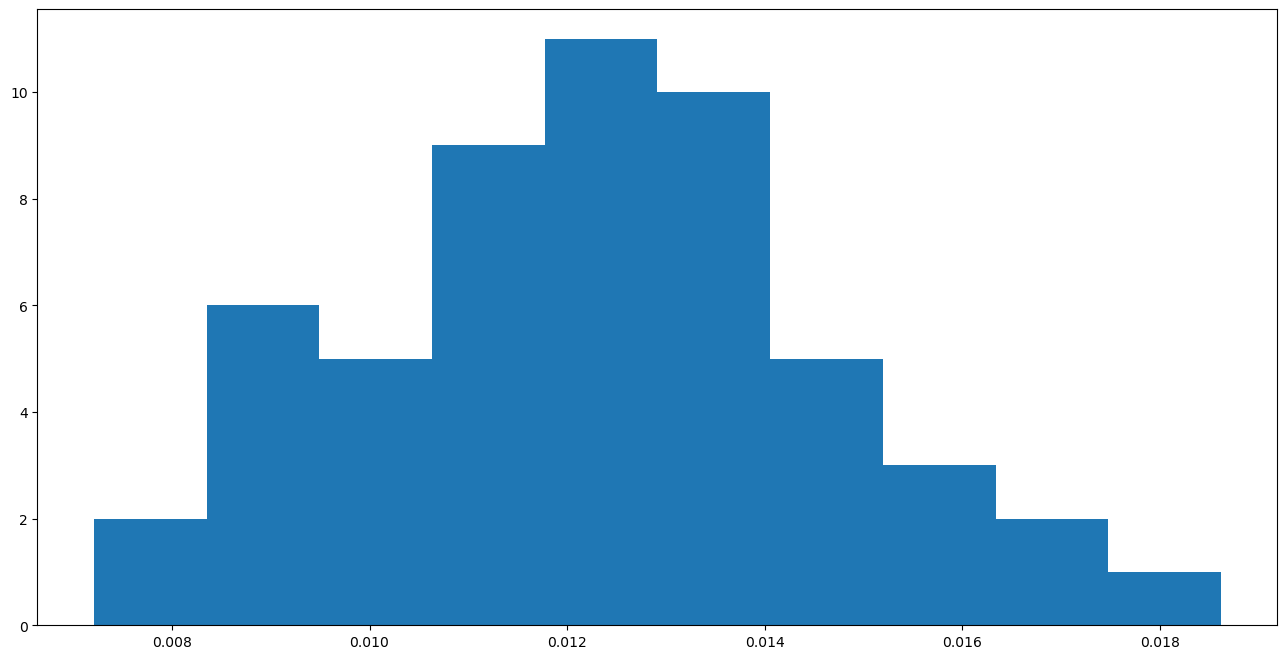

In [415]:
plt.hist(output['mape'])

In [ ]:
future = model.make_future_dataframe(periods=12, freq='MS') # set frequency to monthly
forecast = model.predict(future)
forecast.set_index('ds', inplace = True)

for zipcode in df['census_zcta5_geoid'].unique():
    plt.plot(y_true_dict[zipcode], label='Actual')
    plt.plot(y_pred_dict[zipcode], label='Predicted')
    plt.legend()
    plt.show()

### Cross-Validation with Multivariate Regressors

In [418]:
crossval_dict = {}

for zipcode in atl_df['zipcode'].unique():
    # filter for single zipcode
    zipcode_df = atl_df[atl_df['zipcode'] == zipcode]
    
    # initiate Prophet object and fit on zipcode
    model = Prophet()
    model.add_regressor('mean_rent_mf', standardize = False)
    model.add_regressor('median_income_inflow', standardize = False)
    model.fit(zipcode_df)
    
    cutoffs = pd.to_datetime(['2021-12-01', '2022-06-01', '2022-12-01'])
    df_cv = cross_validation(model, cutoffs=cutoffs, horizon='182 days')

    crossval_dict[zipcode] = df_cv

17:09:13 - cmdstanpy - INFO - Chain [1] start processing
17:09:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:09:14 - cmdstanpy - INFO - Chain [1] start processing
17:09:42 - cmdstanpy - INFO - Chain [1] done processing
17:09:42 - cmdstanpy - INFO - Chain [1] start processing
17:10:13 - cmdstanpy - INFO - Chain [1] done processing
17:10:13 - cmdstanpy - INFO - Chain [1] start processing
17:10:13 - cmdstanpy - INFO - Chain [1] done processing
17:10:14 - cmdstanpy - INFO - Chain [1] start processing
17:10:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:10:14 - cmdstanpy - INFO - Chain [1] start processing
17:10:36 - cmdstanpy - INFO - Chain [1] done processing
17:10:37 - cmdstanpy - INFO - Chain [1] start processing
17:10:46 - cmdstanpy - INFO - Chain [1] done processing
17:10:46 - cmdstanpy - INFO - Chain [1] start processing
17:10:46 - cmdstanpy - INFO - Chain [1] done processing
17:10:46 - cmdstanpy - INFO - Chain [1] start processing
17:10:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:10:47 - cmdstanpy - INFO - Chain [1] start processing
17:11:07 - cmdstanpy - INFO - Chain [1] done processing
17:11:08 - cmdstanpy - INFO - Chain [1] start processing
17:11:26 - cmdstanpy - INFO - Chain [1] done processing
17:11:26 - cmdstanpy - INFO - Chain [1] start processing
17:11:26 - cmdstanpy - INFO - Chain [1] done processing
17:11:26 - cmdstanpy - INFO - Chain [1] start processing
17:11:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:11:27 - cmdstanpy - INFO - Chain [1] start processing
17:11:47 - cmdstanpy - INFO - Chain [1] done processing
17:11:47 - cmdstanpy - INFO - Chain [1] start processing
17:12:13 - cmdstanpy - INFO - Chain [1] done processing
17:12:13 - cmdstanpy - INFO - Chain [1] start processing
17:12:14 - cmdstanpy - INFO - Chain [1] done processing
17:12:14 - cmdstanpy - INFO - Chain [1] start processing
17:12:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:12:14 - cmdstanpy - INFO - Chain [1] start processing
17:12:37 - cmdstanpy - INFO - Chain [1] done processing
17:12:37 - cmdstanpy - INFO - Chain [1] start processing
17:13:00 - cmdstanpy - INFO - Chain [1] done processing
17:13:00 - cmdstanpy - INFO - Chain [1] start processing
17:13:01 - cmdstanpy - INFO - Chain [1] done processing
17:13:01 - cmdstanpy - INFO - Chain [1] start processing
17:13:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:13:01 - cmdstanpy - INFO - Chain [1] start processing
17:13:22 - cmdstanpy - INFO - Chain [1] done processing
17:13:22 - cmdstanpy - INFO - Chain [1] start processing
17:13:47 - cmdstanpy - INFO - Chain [1] done processing
17:13:47 - cmdstanpy - INFO - Chain [1] start processing
17:13:48 - cmdstanpy - INFO - Chain [1] done processing
17:13:48 - cmdstanpy - INFO - Chain [1] start processing
17:13:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:13:48 - cmdstanpy - INFO - Chain [1] start processing
17:14:09 - cmdstanpy - INFO - Chain [1] done processing
17:14:09 - cmdstanpy - INFO - Chain [1] start processing
17:14:24 - cmdstanpy - INFO - Chain [1] done processing
17:14:24 - cmdstanpy - INFO - Chain [1] start processing
17:14:24 - cmdstanpy - INFO - Chain [1] done processing
17:14:24 - cmdstanpy - INFO - Chain [1] start processing
17:14:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:14:25 - cmdstanpy - INFO - Chain [1] start processing
17:14:46 - cmdstanpy - INFO - Chain [1] done processing
17:14:46 - cmdstanpy - INFO - Chain [1] start processing
17:14:48 - cmdstanpy - INFO - Chain [1] done processing
17:14:48 - cmdstanpy - INFO - Chain [1] start processing
17:14:48 - cmdstanpy - INFO - Chain [1] done processing
17:14:48 - cmdstanpy - INFO - Chain [1] start processing
17:14:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:14:49 - cmdstanpy - INFO - Chain [1] start processing
17:15:03 - cmdstanpy - INFO - Chain [1] done processing
17:15:03 - cmdstanpy - INFO - Chain [1] start processing
17:15:09 - cmdstanpy - INFO - Chain [1] done processing
17:15:09 - cmdstanpy - INFO - Chain [1] start processing
17:15:10 - cmdstanpy - INFO - Chain [1] done processing
17:15:10 - cmdstanpy - INFO - Chain [1] start processing
17:15:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:15:10 - cmdstanpy - INFO - Chain [1] start processing
17:15:17 - cmdstanpy - INFO - Chain [1] done processing
17:15:17 - cmdstanpy - INFO - Chain [1] start processing
17:15:38 - cmdstanpy - INFO - Chain [1] done processing
17:15:38 - cmdstanpy - INFO - Chain [1] start processing
17:15:39 - cmdstanpy - INFO - Chain [1] done processing
17:15:39 - cmdstanpy - INFO - Chain [1] start processing
17:15:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:15:39 - cmdstanpy - INFO - Chain [1] start processing
17:15:58 - cmdstanpy - INFO - Chain [1] done processing
17:15:58 - cmdstanpy - INFO - Chain [1] start processing
17:16:17 - cmdstanpy - INFO - Chain [1] done processing
17:16:17 - cmdstanpy - INFO - Chain [1] start processing
17:16:18 - cmdstanpy - INFO - Chain [1] done processing
17:16:18 - cmdstanpy - INFO - Chain [1] start processing
17:16:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:16:18 - cmdstanpy - INFO - Chain [1] start processing
17:16:36 - cmdstanpy - INFO - Chain [1] done processing
17:16:37 - cmdstanpy - INFO - Chain [1] start processing
17:16:42 - cmdstanpy - INFO - Chain [1] done processing
17:16:42 - cmdstanpy - INFO - Chain [1] start processing
17:16:43 - cmdstanpy - INFO - Chain [1] done processing
17:16:43 - cmdstanpy - INFO - Chain [1] start processing
17:16:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:16:43 - cmdstanpy - INFO - Chain [1] start processing
17:17:03 - cmdstanpy - INFO - Chain [1] done processing
17:17:03 - cmdstanpy - INFO - Chain [1] start processing
17:17:11 - cmdstanpy - INFO - Chain [1] done processing
17:17:11 - cmdstanpy - INFO - Chain [1] start processing
17:17:11 - cmdstanpy - INFO - Chain [1] done processing
17:17:11 - cmdstanpy - INFO - Chain [1] start processing
17:17:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:17:12 - cmdstanpy - INFO - Chain [1] start processing
17:17:30 - cmdstanpy - INFO - Chain [1] done processing
17:17:30 - cmdstanpy - INFO - Chain [1] start processing
17:17:39 - cmdstanpy - INFO - Chain [1] done processing
17:17:39 - cmdstanpy - INFO - Chain [1] start processing
17:17:39 - cmdstanpy - INFO - Chain [1] done processing
17:17:39 - cmdstanpy - INFO - Chain [1] start processing
17:17:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:17:40 - cmdstanpy - INFO - Chain [1] start processing
17:17:58 - cmdstanpy - INFO - Chain [1] done processing
17:17:58 - cmdstanpy - INFO - Chain [1] start processing
17:18:18 - cmdstanpy - INFO - Chain [1] done processing
17:18:18 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing
17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:38 - cmdstanpy - INFO - Chain [1] done processing
17:18:38 - cmdstanpy - INFO - Chain [1] start processing
17:18:41 - cmdstanpy - INFO - Chain [1] done processing
17:18:41 - cmdstanpy - INFO - Chain [1] start processing
17:18:42 - cmdstanpy - INFO - Chain [1] done processing
17:18:42 - cmdstanpy - INFO - Chain [1] start processing
17:18:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:18:42 - cmdstanpy - INFO - Chain [1] start processing
17:19:03 - cmdstanpy - INFO - Chain [1] done processing
17:19:03 - cmdstanpy - INFO - Chain [1] start processing
17:19:26 - cmdstanpy - INFO - Chain [1] done processing
17:19:26 - cmdstanpy - INFO - Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing
17:19:27 - cmdstanpy - INFO - Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:19:27 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:43 - cmdstanpy - INFO - Chain [1] done processing
17:19:43 - cmdstanpy - INFO - Chain [1] start processing
17:19:44 - cmdstanpy - INFO - Chain [1] done processing
17:19:44 - cmdstanpy - INFO - Chain [1] start processing
17:19:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:19:44 - cmdstanpy - INFO - Chain [1] start processing
17:20:03 - cmdstanpy - INFO - Chain [1] done processing
17:20:03 - cmdstanpy - INFO - Chain [1] start processing
17:20:22 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:42 - cmdstanpy - INFO - Chain [1] done processing
17:20:42 - cmdstanpy - INFO - Chain [1] start processing
17:21:03 - cmdstanpy - INFO - Chain [1] done processing
17:21:03 - cmdstanpy - INFO - Chain [1] start processing
17:21:03 - cmdstanpy - INFO - Chain [1] done processing
17:21:03 - cmdstanpy - INFO - Chain [1] start processing
17:21:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:21:03 - cmdstanpy - INFO - Chain [1] start processing
17:21:22 - cmdstanpy - INFO - Chain [1] done processing
17:21:22 - cmdstanpy - INFO - Chain [1] start processing
17:21:42 - cmdstanpy - INFO - Chain [1] done processing
17:21:42 - cmdstanpy - INFO - Chain [1] start processing
17:21:42 - cmdstanpy - INFO - Chain [1] done processing
17:21:42 - cmdstanpy - INFO - Chain [1] start processing
17:21:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:21:42 - cmdstanpy - INFO - Chain [1] start processing
17:21:48 - cmdstanpy - INFO - Chain [1] done processing
17:21:48 - cmdstanpy - INFO - Chain [1] start processing
17:21:53 - cmdstanpy - INFO - Chain [1] done processing
17:21:53 - cmdstanpy - INFO - Chain [1] start processing
17:21:53 - cmdstanpy - INFO - Chain [1] done processing
17:21:53 - cmdstanpy - INFO - Chain [1] start processing
17:21:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:21:54 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:19 - cmdstanpy - INFO - Chain [1] done processing
17:22:19 - cmdstanpy - INFO - Chain [1] start processing
17:22:20 - cmdstanpy - INFO - Chain [1] done processing
17:22:20 - cmdstanpy - INFO - Chain [1] start processing
17:22:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:22:20 - cmdstanpy - INFO - Chain [1] start processing
17:22:39 - cmdstanpy - INFO - Chain [1] done processing
17:22:39 - cmdstanpy - INFO - Chain [1] start processing
17:22:42 - cmdstanpy - INFO - Chain [1] done processing
17:22:42 - cmdstanpy - INFO - Chain [1] start processing
17:22:42 - cmdstanpy - INFO - Chain [1] done processing
17:22:42 - cmdstanpy - INFO - Chain [1] start processing
17:22:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:22:43 - cmdstanpy - INFO - Chain [1] start processing
17:23:01 - cmdstanpy - INFO - Chain [1] done processing
17:23:01 - cmdstanpy - INFO - Chain [1] start processing
17:23:06 - cmdstanpy - INFO - Chain [1] done processing
17:23:06 - cmdstanpy - INFO - Chain [1] start processing
17:23:07 - cmdstanpy - INFO - Chain [1] done processing
17:23:07 - cmdstanpy - INFO - Chain [1] start processing
17:23:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:23:07 - cmdstanpy - INFO - Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing
17:23:29 - cmdstanpy - INFO - Chain [1] start processing
17:23:50 - cmdstanpy - INFO - Chain [1] done processing
17:23:50 - cmdstanpy - INFO - Chain [1] start processing
17:23:50 - cmdstanpy - INFO - Chain [1] done processing
17:23:50 - cmdstanpy - INFO - Chain [1] start processing
17:23:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:23:51 - cmdstanpy - INFO - Chain [1] start processing
17:23:52 - cmdstanpy - INFO - Chain [1] done processing
17:23:52 - cmdstanpy - INFO - Chain [1] start processing
17:23:55 - cmdstanpy - INFO - Chain [1] done processing
17:23:55 - cmdstanpy - INFO - Chain [1] start processing
17:23:55 - cmdstanpy - INFO - Chain [1] done processing
17:23:55 - cmdstanpy - INFO - Chain [1] start processing
17:23:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:23:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:14 - cmdstanpy - INFO - Chain [1] done processing
17:24:14 - cmdstanpy - INFO - Chain [1] start processing
17:24:34 - cmdstanpy - INFO - Chain [1] done processing
17:24:34 - cmdstanpy - INFO - Chain [1] start processing
17:24:35 - cmdstanpy - INFO - Chain [1] done processing
17:24:35 - cmdstanpy - INFO - Chain [1] start processing
17:24:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:24:35 - cmdstanpy - INFO - Chain [1] start processing
17:24:53 - cmdstanpy - INFO - Chain [1] done processing
17:24:53 - cmdstanpy - INFO - Chain [1] start processing
17:24:55 - cmdstanpy - INFO - Chain [1] done processing
17:24:55 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing
17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:24:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:24:56 - cmdstanpy - INFO - Chain [1] start processing
17:25:14 - cmdstanpy - INFO - Chain [1] done processing
17:25:14 - cmdstanpy - INFO - Chain [1] start processing
17:25:18 - cmdstanpy - INFO - Chain [1] done processing
17:25:18 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing
17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:25:19 - cmdstanpy - INFO - Chain [1] start processing
17:25:38 - cmdstanpy - INFO - Chain [1] done processing
17:25:38 - cmdstanpy - INFO - Chain [1] start processing
17:25:58 - cmdstanpy - INFO - Chain [1] done processing
17:25:58 - cmdstanpy - INFO - Chain [1] start processing
17:25:58 - cmdstanpy - INFO - Chain [1] done processing
17:25:58 - cmdstanpy - INFO - Chain [1] start processing
17:25:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:25:58 - cmdstanpy - INFO - Chain [1] start processing
17:26:16 - cmdstanpy - INFO - Chain [1] done processing
17:26:17 - cmdstanpy - INFO - Chain [1] start processing
17:26:37 - cmdstanpy - INFO - Chain [1] done processing
17:26:37 - cmdstanpy - INFO - Chain [1] start processing
17:26:37 - cmdstanpy - INFO - Chain [1] done processing
17:26:37 - cmdstanpy - INFO - Chain [1] start processing
17:26:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:26:38 - cmdstanpy - INFO - Chain [1] start processing
17:26:51 - cmdstanpy - INFO - Chain [1] done processing
17:26:52 - cmdstanpy - INFO - Chain [1] start processing
17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing
17:27:04 - cmdstanpy - INFO - Chain [1] done processing
17:27:04 - cmdstanpy - INFO - Chain [1] start processing
17:27:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:27:05 - cmdstanpy - INFO - Chain [1] start processing
17:27:11 - cmdstanpy - INFO - Chain [1] done processing
17:27:11 - cmdstanpy - INFO - Chain [1] start processing
17:27:15 - cmdstanpy - INFO - Chain [1] done processing
17:27:15 - cmdstanpy - INFO - Chain [1] start processing
17:27:15 - cmdstanpy - INFO - Chain [1] done processing
17:27:15 - cmdstanpy - INFO - Chain [1] start processing
17:27:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:27:16 - cmdstanpy - INFO - Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
17:27:34 - cmdstanpy - INFO - Chain [1] start processing
17:27:54 - cmdstanpy - INFO - Chain [1] done processing
17:27:54 - cmdstanpy - INFO - Chain [1] start processing
17:27:54 - cmdstanpy - INFO - Chain [1] done processing
17:27:54 - cmdstanpy - INFO - Chain [1] start processing
17:27:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:27:55 - cmdstanpy - INFO - Chain [1] start processing
17:28:04 - cmdstanpy - INFO - Chain [1] done processing
17:28:04 - cmdstanpy - INFO - Chain [1] start processing
17:28:06 - cmdstanpy - INFO - Chain [1] done processing
17:28:06 - cmdstanpy - INFO - Chain [1] start processing
17:28:06 - cmdstanpy - INFO - Chain [1] done processing
17:28:07 - cmdstanpy - INFO - Chain [1] start processing
17:28:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:28:07 - cmdstanpy - INFO - Chain [1] start processing
17:28:25 - cmdstanpy - INFO - Chain [1] done processing
17:28:25 - cmdstanpy - INFO - Chain [1] start processing
17:28:47 - cmdstanpy - INFO - Chain [1] done processing
17:28:47 - cmdstanpy - INFO - Chain [1] start processing
17:28:48 - cmdstanpy - INFO - Chain [1] done processing
17:28:48 - cmdstanpy - INFO - Chain [1] start processing
17:28:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:28:48 - cmdstanpy - INFO - Chain [1] start processing
17:29:14 - cmdstanpy - INFO - Chain [1] done processing
17:29:14 - cmdstanpy - INFO - Chain [1] start processing
17:29:18 - cmdstanpy - INFO - Chain [1] done processing
17:29:18 - cmdstanpy - INFO - Chain [1] start processing
17:29:18 - cmdstanpy - INFO - Chain [1] done processing
17:29:18 - cmdstanpy - INFO - Chain [1] start processing
17:29:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:29:19 - cmdstanpy - INFO - Chain [1] start processing
17:29:23 - cmdstanpy - INFO - Chain [1] done processing
17:29:23 - cmdstanpy - INFO - Chain [1] start processing
17:29:40 - cmdstanpy - INFO - Chain [1] done processing
17:29:40 - cmdstanpy - INFO - Chain [1] start processing
17:29:40 - cmdstanpy - INFO - Chain [1] done processing
17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:29:41 - cmdstanpy - INFO - Chain [1] start processing
17:29:49 - cmdstanpy - INFO - Chain [1] done processing
17:29:49 - cmdstanpy - INFO - Chain [1] start processing
17:30:10 - cmdstanpy - INFO - Chain [1] done processing
17:30:10 - cmdstanpy - INFO - Chain [1] start processing
17:30:11 - cmdstanpy - INFO - Chain [1] done processing
17:30:11 - cmdstanpy - INFO - Chain [1] start processing
17:30:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:30:11 - cmdstanpy - INFO - Chain [1] start processing
17:30:18 - cmdstanpy - INFO - Chain [1] done processing
17:30:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:45 - cmdstanpy - INFO - Chain [1] done processing
17:31:45 - cmdstanpy - INFO - Chain [1] start processing
17:31:46 - cmdstanpy - INFO - Chain [1] done processing
17:31:46 - cmdstanpy - INFO - Chain [1] start processing
17:31:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:31:47 - cmdstanpy - INFO - Chain [1] start processing
17:31:49 - cmdstanpy - INFO - Chain [1] done processing
17:31:49 - cmdstanpy - INFO - Chain [1] start processing
17:31:56 - cmdstanpy - INFO - Chain [1] done processing
17:31:56 - cmdstanpy - INFO - Chain [1] start processing
17:31:57 - cmdstanpy - INFO - Chain [1] done processing
17:31:57 - cmdstanpy - INFO - Chain [1] start processing
17:31:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:31:57 - cmdstanpy - INFO - Chain [1] start processing
17:32:18 - cmdstanpy - INFO - Chain [1] done processing
17:32:18 - cmdstanpy - INFO - Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
17:32:22 - cmdstanpy - INFO - Chain [1] start processing
17:32:22 - cmdstanpy - INFO - Chain [1] done processing
17:32:22 - cmdstanpy - INFO - Chain [1] start processing
17:32:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:32:23 - cmdstanpy - INFO - Chain [1] start processing
17:32:33 - cmdstanpy - INFO - Chain [1] done processing
17:32:33 - cmdstanpy - INFO - Chain [1] start processing
17:32:54 - cmdstanpy - INFO - Chain [1] done processing
17:32:54 - cmdstanpy - INFO - Chain [1] start processing
17:32:55 - cmdstanpy - INFO - Chain [1] done processing
17:32:55 - cmdstanpy - INFO - Chain [1] start processing
17:32:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:32:55 - cmdstanpy - INFO - Chain [1] start processing
17:33:14 - cmdstanpy - INFO - Chain [1] done processing
17:33:14 - cmdstanpy - INFO - Chain [1] start processing
17:33:35 - cmdstanpy - INFO - Chain [1] done processing
17:33:35 - cmdstanpy - INFO - Chain [1] start processing
17:33:35 - cmdstanpy - INFO - Chain [1] done processing
17:33:35 - cmdstanpy - INFO - Chain [1] start processing
17:33:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:33:36 - cmdstanpy - INFO - Chain [1] start processing
17:33:36 - cmdstanpy - INFO - Chain [1] done processing
17:33:36 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing
17:33:40 - cmdstanpy - INFO - Chain [1] start processing
17:33:40 - cmdstanpy - INFO - Chain [1] done processing
17:33:40 - cmdstanpy - INFO - Chain [1] start processing
17:33:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:33:41 - cmdstanpy - INFO - Chain [1] start processing
17:33:59 - cmdstanpy - INFO - Chain [1] done processing
17:33:59 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:19 - cmdstanpy - INFO - Chain [1] done processing
17:34:19 - cmdstanpy - INFO - Chain [1] start processing
17:34:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:34:20 - cmdstanpy - INFO - Chain [1] start processing
17:34:21 - cmdstanpy - INFO - Chain [1] done processing
17:34:21 - cmdstanpy - INFO - Chain [1] start processing
17:34:25 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing
17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:34:26 - cmdstanpy - INFO - Chain [1] start processing
17:34:45 - cmdstanpy - INFO - Chain [1] done processing
17:34:45 - cmdstanpy - INFO - Chain [1] start processing
17:35:04 - cmdstanpy - INFO - Chain [1] done processing
17:35:04 - cmdstanpy - INFO - Chain [1] start processing
17:35:05 - cmdstanpy - INFO - Chain [1] done processing
17:35:05 - cmdstanpy - INFO - Chain [1] start processing
17:35:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:35:05 - cmdstanpy - INFO - Chain [1] start processing
17:35:23 - cmdstanpy - INFO - Chain [1] done processing
17:35:23 - cmdstanpy - INFO - Chain [1] start processing
17:35:34 - cmdstanpy - INFO - Chain [1] done processing
17:35:34 - cmdstanpy - INFO - Chain [1] start processing
17:35:34 - cmdstanpy - INFO - Chain [1] done processing
17:35:34 - cmdstanpy - INFO - Chain [1] start processing
17:35:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:35:35 - cmdstanpy - INFO - Chain [1] start processing
17:35:53 - cmdstanpy - INFO - Chain [1] done processing
17:35:53 - cmdstanpy - INFO - Chain [1] start processing
17:36:12 - cmdstanpy - INFO - Chain [1] done processing
17:36:12 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing
17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:36:13 - cmdstanpy - INFO - Chain [1] start processing
17:36:31 - cmdstanpy - INFO - Chain [1] done processing
17:36:31 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:52 - cmdstanpy - INFO - Chain [1] done processing
17:36:52 - cmdstanpy - INFO - Chain [1] start processing
17:36:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:36:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing
17:37:11 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing
17:37:16 - cmdstanpy - INFO - Chain [1] start processing
17:37:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:32 - cmdstanpy - INFO - Chain [1] done processing
17:37:32 - cmdstanpy - INFO - Chain [1] start processing
17:37:52 - cmdstanpy - INFO - Chain [1] done processing
17:37:53 - cmdstanpy - INFO - Chain [1] start processing
17:37:53 - cmdstanpy - INFO - Chain [1] done processing


In [419]:
for zipcode in atl_df['zipcode'].unique():
    output_zip = []
    output_zip.append(zipcode)
    output_zip.append('crossval_multiv_3fold')
    output_zip.append(performance_metrics(crossval_dict[zipcode])['mape'].mean())
    output_zip.append(performance_metrics(crossval_dict[zipcode])['mae'].mean())
    output_zip.append(performance_metrics(crossval_dict[zipcode])['mse'].mean())
    output.loc[len(output)] = output_zip

output.tail()

,zip,model,mape,mae,mse
103,30349,crossval_multiv_3fold,0.012678,2.526617,12.640338
104,30350,crossval_multiv_3fold,0.012466,2.363454,9.496784
105,30354,crossval_multiv_3fold,0.018253,3.968342,26.928766
106,30360,crossval_multiv_3fold,0.023017,4.337207,29.973335
107,30363,crossval_multiv_3fold,0.024757,7.768405,93.700308


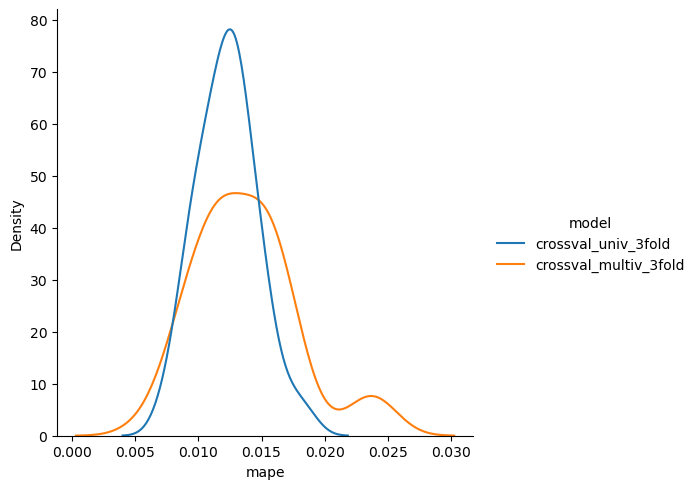

In [420]:
sns.displot(output, x="mape", hue="model", kind="kde")

In [ ]:
# code for generating future values of each regressor for the future dataset
# using prophet prediction

# https://stackoverflow.com/questions/64822488/how-to-use-prophets-make-future-dataframe-with-multiple-regressors

### Univariate by Zip, Train Test Split

In [436]:
traintest_dict = {}

for zipcode in atl_df['zipcode'].unique():
    
    # filter for single zipcode
    zipcode_df = atl_df[atl_df['zipcode'] == zipcode]
    tss = TimeSeriesSplit(n_splits = 2, test_size = 6) # hold out 6 months as test set

    for train_index, test_index in tss.split(zipcode_df):
        df_train, df_test = zipcode_df.iloc[train_index, :], zipcode_df.iloc[test_index,:]
    
    # initiate Prophet object and fit on training set
    model = Prophet()
    model.fit(df_train)
    
    forecast = model.predict(zipcode_df)

    y_true_test = zipcode_df.iloc[test_index, :]['y'].reset_index()
    y_pred_test = forecast.iloc[test_index, :]['yhat'].reset_index(drop = True)
    test = pd.concat([y_true_test, y_pred_test], axis = 1)

    traintest_dict[zipcode] = test

07:59:07 - cmdstanpy - INFO - Chain [1] start processing
07:59:07 - cmdstanpy - INFO - Chain [1] done processing
07:59:07 - cmdstanpy - INFO - Chain [1] start processing
07:59:08 - cmdstanpy - INFO - Chain [1] done processing
07:59:08 - cmdstanpy - INFO - Chain [1] start processing
07:59:09 - cmdstanpy - INFO - Chain [1] done processing
07:59:09 - cmdstanpy - INFO - Chain [1] start processing
07:59:09 - cmdstanpy - INFO - Chain [1] done processing
07:59:10 - cmdstanpy - INFO - Chain [1] start processing
07:59:10 - cmdstanpy - INFO - Chain [1] done processing
07:59:10 - cmdstanpy - INFO - Chain [1] start processing
07:59:11 - cmdstanpy - INFO - Chain [1] done processing
07:59:11 - cmdstanpy - INFO - Chain [1] start processing
07:59:12 - cmdstanpy - INFO - Chain [1] done processing
07:59:12 - cmdstanpy - INFO - Chain [1] start processing
07:59:12 - cmdstanpy - INFO - Chain [1] done processing
07:59:13 - cmdstanpy - INFO - Chain [1] start processing
07:59:13 - cmdstanpy - INFO - Chain [1]

In [447]:
for zipcode in atl_df['zipcode'].unique():
    output_zip = []
    output_zip.append(zipcode)
    output_zip.append('traintest_univ')
    output_zip.append(mean_absolute_percentage_error(traintest_dict[zipcode]['y'], traintest_dict[zipcode]['yhat']))
    output_zip.append(mean_absolute_error(traintest_dict[zipcode]['y'], traintest_dict[zipcode]['yhat']))
    output_zip.append(mean_squared_error(traintest_dict[zipcode]['y'], traintest_dict[zipcode]['yhat']))
    output.loc[len(output)] = output_zip

output.tail()

,zip,model,mape,mae,mse
157,30349,traintest_univ,0.011814,2.421660,8.579751
158,30350,traintest_univ,0.013289,2.562431,8.766449
159,30354,traintest_univ,0.011790,2.652900,10.992218
160,30360,traintest_univ,0.012758,2.482953,8.422843
161,30363,traintest_univ,0.013516,4.394867,30.144125


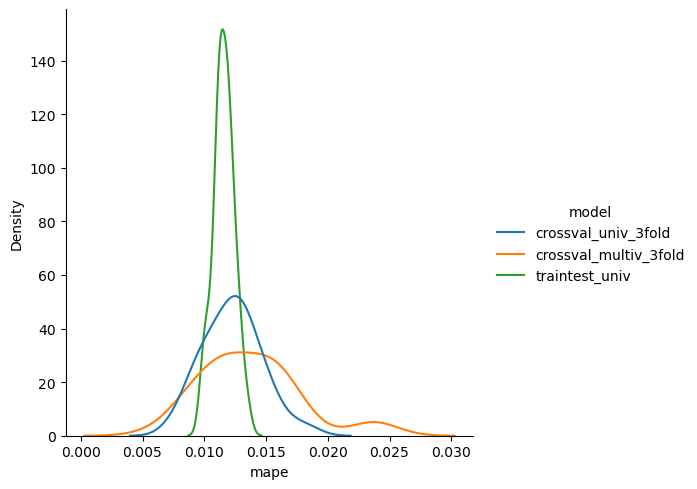

In [448]:
sns.displot(output, x="mape", hue="model", kind="kde")